In [ ]:
!pip install optuna plotly transformers tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.4 MB/s eta 0:00:00


Due to the obtuna library plotting code, cells must be reran in order to produce their desired outputs. As it can take a few hours to redo both the BERT embedding process as well as the model training processes (on a 16 VRAM GPU), as well as the fact that the results may differ when reran, it is recommended to clone the GitHub repository and run only this section (ending at feature the extraction section) and the loading models section onwards.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
Train_Bodies_df = pd.read_csv('train_bodies.csv')
Train_Headlines_Labels_df = pd.read_csv('train_stances.csv')

In [ ]:
Train_Bodies_df

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
...,...,...
1678,2528,Intelligence agencies hunting for identity of ...
1679,2529,"While Daleks ""know no fear"" and ""must not fear..."
1680,2530,More than 200 schoolgirls were kidnapped in Ap...
1681,2531,A Guantanamo Bay prisoner released last year a...


In [ ]:
Train_Headlines_Labels_df

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
...,...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,1681,unrelated
49968,Brian Williams slams social media for speculat...,2419,unrelated
49969,Mexico Says Missing Students Not Found In Firs...,1156,agree
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,1012,discuss


In [ ]:
Train_Data_df = pd.merge(Train_Bodies_df, Train_Headlines_Labels_df, on='Body ID')

In [ ]:
Train_Data_df

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree


In [ ]:
Train_Data_df.columns

Index(['Body ID', 'articleBody', 'Headline', 'Stance'], dtype='object')

In [ ]:
Train_Data_df.drop('Body ID', axis=1,inplace=True)

In [ ]:
Train_Data_df.columns

Index(['articleBody', 'Headline', 'Stance'], dtype='object')

One way to implement TF-IDF is to use the articleBody and Headline columns to act as separate documents and then apply TF-IDF. Another is to combine each pair into a string with each combination acting as one document. 

For the latter case, and for the transformer implementation, a new column is made. It contains special tokens to between the two texts in an attempt to make the fact that they are separate texts clearer. This is for the case of the transformer, BERT, which has been pretrained to understand these tokens.

In [ ]:
Train_Data_df['input'] = '[CLS]' + ' HEADLINE:' + Train_Data_df.Headline + ' [SEP]' + ' BODY:' + Train_Data_df.articleBody + ' [SEP]'

In [ ]:
Train_Data_df

,articleBody,Headline,Stance,input
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated,"[CLS] HEADLINE:Soldier shot, Parliament locked..."
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated,[CLS] HEADLINE:Tourist dubbed ‘Spider Man’ aft...
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated,[CLS] HEADLINE:Luke Somers 'killed in failed r...
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated,[CLS] HEADLINE:BREAKING: Soldier shot at War M...
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated,[CLS] HEADLINE:Giant 8ft 9in catfish weighing ...
...,...,...,...,...
49967,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree,[CLS] HEADLINE:Pizza delivery man gets tipped ...
49968,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree,"[CLS] HEADLINE:Pizza delivery man gets $2,000 ..."
49969,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree,[CLS] HEADLINE:Luckiest Pizza Delivery Guy Eve...
49970,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree,[CLS] HEADLINE:Ann Arbor pizza delivery driver...


In [ ]:
# For 2a) creating a new column for binary classification of related or unrelated
Train_Data_df['Relation'] = Train_Data_df['Stance'].apply(lambda x: 1 if x in ['agree', 'disagree', 'discuss'] else 0)
# For 2b) creating a new column for multi class agree/Disagree/Discuss classification of agree, disagree, discuss
Train_Data_df['ADD'] = Train_Data_df['Stance'].apply(lambda x: 2 if x == 'agree' else (1 if x == 'disagree' else 0))

In [ ]:
Train_Data_df['Stance'], Train_Data_df['ADD']

(0        unrelated
 1        unrelated
 2        unrelated
 3        unrelated
 4        unrelated
            ...    
 49967        agree
 49968        agree
 49969        agree
 49970        agree
 49971        agree
 Name: Stance, Length: 49972, dtype: object,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 49967    2
 49968    2
 49969    2
 49970    2
 49971    2
 Name: ADD, Length: 49972, dtype: int64)

In [ ]:
# Shuffling dataframe just in case there are any relationships in the orders of the entries
Train_Data_df = Train_Data_df.sample(frac=1)

Viewing class imbalances.

Unbalance Ratio is calculated for use in XGBoost Binary Classification model parameter scale_pos_weight.



In [ ]:
print(Train_Data_df['Relation'].describe())
print('Number of unrelated:', len(Train_Data_df[Train_Data_df['Relation'] == 0]))
print('Number of related:', len(Train_Data_df[Train_Data_df['Relation'] == 1]))
print('Unbalance Ratio:', (len(Train_Data_df[Train_Data_df['Relation'] == 0])/(len(Train_Data_df[Train_Data_df['Relation'] == 1]))))

count    49972.000000
mean         0.268690
std          0.443283
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Relation, dtype: float64
Number of unrelated: 36545
Number of related: 13427
Unbalance Ratio: 2.72175467341923


In [ ]:
print(Train_Data_df['ADD'].describe())
print('Number of discuss:', len(Train_Data_df[Train_Data_df['ADD'] == 0]))  
print('Number of disagree:', len(Train_Data_df[Train_Data_df['ADD'] == 1]))
print('Number of agree:', len(Train_Data_df[Train_Data_df['ADD'] == 2]))

count    49972.000000
mean         0.164012
std          0.533217
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: ADD, dtype: float64
Number of discuss: 45454
Number of disagree: 840
Number of agree: 3678


Regarding how to split the dataset. Train_Data_df created from the train_bodies.csv and train_stances.csv files is the entire available dataset for training and testing. This is because the test dataset .csv files do not have labels. 

Train_Data_df will be divided as follows:
- 80% will be used as combined training and validation data for task 2a) and task 2b). I.E, 64% of the full dataset will be used for training and 16% for validation.
- 20% will be used as purely as test data for both task 2a) and 2b), as well as their combination in 2c).



In [ ]:
# Do not run this cell multiple times. It will continuously split the training dataframe up. 

# Randomly sampling 20% of the data to create test dataset
Test_Data_df = Train_Data_df.sample(frac=0.2, random_state=5)

# Removing this data from the training dataframe
Train_Data_df = Train_Data_df.drop(Test_Data_df.index)

# Checking the sizes of the resulting dataframes
print(f"Train_Data_df size: {Train_Data_df.shape}")
print(f"Test_Data_df size: {Test_Data_df.shape}")

Train_Data_df size: (39978, 6)
Test_Data_df size: (9994, 6)


In [ ]:
# Splitting training dataset into training and validation datasets
from sklearn.model_selection import train_test_split
# For binary classification
X_Train, X_Valid, Y_Train, Y_Valid = train_test_split(Train_Data_df['input'], 
                                                      Train_Data_df['Relation'].values,
                                                      test_size=0.20,
                                                      random_state=0)

# For Three class classification
Y_Train_ADD, Y_Valid_ADD = train_test_split(Train_Data_df['ADD'].values, 
                                            test_size=0.20,
                                            random_state=0)


print(X_Train.shape)
print(X_Valid.shape)

(31982,)
(7996,)


In [ ]:
X_Test, Y_Test, Y_Test_ADD = Test_Data_df['input'],Test_Data_df['Relation'].values,Test_Data_df['ADD'].values

In [ ]:
X_Test.shape

(9994,)

In [ ]:
X_Train,Y_Train

(106      [CLS] HEADLINE:Kim Jong-Un 'bans the name Kim ...
 35626    [CLS] HEADLINE:Meteorite strike in Nicaragua p...
 31151    [CLS] HEADLINE:Detroit Police Issue Statement ...
 25496    [CLS] HEADLINE:Audio recording of Michael Brow...
 35792    [CLS] HEADLINE:Somalia Shebab chief Ahmed Abdi...
                                ...                        
 26783    [CLS] HEADLINE:Reports Isis fighters have cont...
 38659    [CLS] HEADLINE:Teen Makes $72 Million on the S...
 45712    [CLS] HEADLINE:Texas Plumber Isn't Sure How Ex...
 11276    [CLS] HEADLINE:#Hairgate: Reports of iPhone 6 ...
 38657    [CLS] HEADLINE:Street Artist BANKSY Arrested? ...
 Name: input, Length: 31982, dtype: object,
 array([0, 0, 1, ..., 0, 0, 1]))

## Preparing dataset labels for models

In [ ]:
Y_Train = Y_Train.tolist() 
Y_Valid = Y_Valid.tolist() 
Y_Test = Y_Test.tolist() 

In [ ]:
# Calculating class_weight parameter for use in Keras Neural Networks 
# XGBoost Models have a similar parameter, scale_pos_weight, already calculated to be 2.72175467341923 for binary classification
from sklearn.utils.class_weight import compute_class_weight

Binary_Class_Weights = compute_class_weight(
                                class_weight = "balanced",
                                classes = np.unique(Y_Train),
                                y = Y_Train                                                    
                            )

Binary_Class_Weightings = {i : Binary_Class_Weights[i] for i in range(2)}
print(Binary_Class_Weightings)

Triple_Class_Weights = compute_class_weight(
                                class_weight = "balanced",
                                classes = np.unique(Y_Train_ADD),
                                y = Y_Train_ADD                                                    
                            )
Triple_Class_Weightings = {i : Triple_Class_Weights[i] for i in range(3)}
print(Triple_Class_Weightings)

{0: 0.6852502571134728, 1: 1.849525792273884}
{0: 0.3665222672992734, 1: 20.228969006957623, 2: 4.500070353172928}


In [ ]:
from keras.utils import to_categorical

Y_Train_ADD = to_categorical(Y_Train_ADD, 3)
Y_Valid_ADD = to_categorical(Y_Valid_ADD, 3)
Y_Test_ADD = to_categorical(Y_Test_ADD, 3)

# Feature Extraction

## TF-IDF Cosine Scores


Calculating cosine similarities with TF-IDF. 

To do so, the each combined headline and text body string will be split into two separate lists containing just the headlines and just the bodies, and these lists will be concatenated. <br>

Then the TD-IDF vectoriser is applied and cosine similarity values calculated between each corresponding headline-body pair.

The headlines and bodies must be separated so that every individual headline and body is considered as its own document as the cosine similarity is to be calculated between documents.

### Task 1a)

In [ ]:
def get_cosine_scores(X_Data):
    Headlines = []
    Text_Bodies = []

    for x in X_Data:
        SubStrings = x.split("[SEP]")
        Headline = SubStrings[0].split("HEADLINE:")[1].strip()
        Text_Body = SubStrings[1].split("BODY:")[1].strip()
        Headlines.append(Headline)
        Text_Bodies.append(Text_Body)

    Combined_HB = Headlines + Text_Bodies

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    # Max df doesn't need to be 1 are we're not using separation tokens
    Vectorizer = TfidfVectorizer(lowercase=True, min_df=0.1, max_df=0.85)
    Combined_HB_Vectors = Vectorizer.fit_transform(Combined_HB)

    # Calculate and store cosine similarity scores for each corresponding headline-body pair
    N_Headlines = len(Headlines)
    Cosine_HB_Scores = []
    for i in range(N_Headlines):
        Cosine_Sim_Score = cosine_similarity(Combined_HB_Vectors[i], Combined_HB_Vectors[N_Headlines + i])
        Cosine_HB_Scores.append(Cosine_Sim_Score[0][0])

    Cosine_HB_Scores = np.array(Cosine_HB_Scores).reshape(-1, 1)
    
    return Cosine_HB_Scores

Cosine_X_Train = get_cosine_scores(X_Train)
Cosine_X_Valid = get_cosine_scores(X_Valid)
Cosine_X_Test = get_cosine_scores(X_Test)

Unlike the cosine similarity implementation, for a combined headline and body string TFIDF application, the tokens within the combined strings (e.g. [SEP]) must be retained. To do so, max_df must be set as 1.0 as these tokens will appear in every document. The downside of this is both a larger usage of memory via the unavoidable retention of common and unhelpful words. <br>

While the memory usage can be managable if the TFIDF matrices are sparse, for certain model implementations scipy sparse matrices cannot be accepted as input, and so must be converted into dense arrays taking intense amounts of memory. 

In the case an early and now unused CUML RandomForestClassifier, an attempt to resolve this was made. A training loop was created such that the training data was split into batches and only the batch to be trained was converted into a dense matrix, to then be removed from memory after use. However, this implementation was scrapped because in such a case, calculating the training loss after each epoch is not possible. The full training dataset must be converted into a dense matrix in order to make predictions upon it. 

As a result, the value for min_df, heavily controlling the number of features extracted, was set to a stricter threshold to consequently significantly reduce the size of the vocabulary list. Dependant on the specific circumstances, this may or may not decrease performance, but it will decrease the memory usage to be at managable levels. 

## BERT Transformer Embeddings

Regarding preprocessing. For a pretrained Transformer model, it will come with knowledge regarding semantics and language already. TF-IDF will not contain that, but document frequency information. 



### Task 1b)

Embeddings are generated in batches due to GPU memory restraints. Note, the batch size of 296 was picked to be a multiple of 8 and works on a 16 VRAM GPU.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import gc

def generate_embeddings(X_Data, batch_size=296):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    model = BertModel.from_pretrained("bert-base-uncased")
    model = model.to(device)  

    def bert_embedder(sentences):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=512, add_special_tokens=False)
        inputs = inputs.to(device)  
        with torch.no_grad(): # No need as only embedder is used
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  
        return embeddings

    sentences = X_Data.values.astype('U').tolist() # There should be no need to use .astype('U') as bert-base-uncased is being used

    all_embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]
        batch_embeddings = bert_embedder(batch_sentences)
        all_embeddings.append(batch_embeddings)
        del batch_sentences, batch_embeddings
        torch.cuda.empty_cache()

    embeddings = np.concatenate(all_embeddings, axis=0)
    
    del all_embeddings
    del model, tokenizer  
    gc.collect()  
    torch.cuda.empty_cache()  

    return embeddings

In [ ]:
#X_Train_BertEmbed = generate_embeddings(X_Train)
#np.save('X_Train_BertEmbed.npy', embeddings)
X_Train_BertEmbed = np.load('X_Train_BertEmbed.npy')

#X_Valid_BertEmbed = generate_embeddings(X_Valid)
#np.save('X_Valid_BertEmbed.npy', X_Valid_BertEmbed)
X_Valid_BertEmbed = np.load('X_Valid_BertEmbed.npy')

#X_Test_BertEmbed = generate_embeddings(X_Test)
#np.save('X_Test_BertEmbed.npy', X_Test_BertEmbed)
X_Test_BertEmbed = np.load('X_Test_BertEmbed.npy')

In [ ]:
from sklearn.decomposition import PCA

def reduce_dimensionality(embeddings, n_components=100):
    #pca = PCA(n_components=0.95) # Used initially to find 95% of variance
    pca = PCA(n_components=244)
    pca_embeddings = pca.fit_transform(embeddings)
    return pca_embeddings

# Bert always produces 768 dimensions
X_Train_BE_PCA = reduce_dimensionality(X_Train_BertEmbed)
X_Valid_BE_PCA = reduce_dimensionality(X_Valid_BertEmbed)
X_Test_BE_PCA = reduce_dimensionality(X_Test_BertEmbed)

In [ ]:
print(Cosine_X_Train.shape) # TF-IDF cosine for comparison
print(X_Train_BertEmbed.shape)
print(X_Train_BE_PCA.shape)
# 95% of the variance is n_components = 240-245 in PCA (slight difference between training, validation and test data)

NameError: ignored

# Model Creation and Hyperparameter Optimisation





In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import optuna
from optuna.visualization import plot_optimization_history
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score


def create_trial_model(trial, model_type, X_train, y_train):
    if model_type == 'xgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
            'tree_method': 'gpu_hist',
            'scale_pos_weight': '2.72'
        } 
        model = XGBClassifier(**params, eval_metric='logloss')

        print(f'Attempting parameters: {params}')
        model.fit(X_train, y_train)
    elif model_type == 'nn':
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2) 
        n_units = trial.suggest_int('n_units', 32, 128, step=32)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)

        model = Sequential()
        input_shape=(X_train.shape[1],)
        model.add(Dense(n_units, input_shape=input_shape))
        model.add(Dropout(dropout_rate))
        model.add(Dense(n_units, activation='relu')) 
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid')) 
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10),
            ModelCheckpoint(filepath=f'/content/drive/MyDrive/NLP/Studies/{model_type}.h5', monitor='val_loss', save_best_only=True)
        ]

        Binary_Class_Weightings = {0: 0.682675887978142, 1: 1.8685440523486796} 

        print(f'Attempting parameters: {learning_rate},{n_units},{dropout_rate}')
        model.fit(X_train, np.array(y_train), epochs=1000, batch_size=32, verbose=0, validation_split=0.2, class_weight=Binary_Class_Weightings, callbacks=callbacks)

    elif model_type == 'nn_add':
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3) 
        n_units = trial.suggest_int('n_units', 32, 256, step=32) 
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)

        model = Sequential()
        input_shape=(X_train.shape[1],)
        model.add(Dense(n_units, input_shape=input_shape, activation='relu')) 
        model.add(Dropout(dropout_rate))
        model.add(Dense(n_units, activation='relu')) 
        model.add(Dropout(dropout_rate))
        model.add(Dense(n_units, activation='relu')) 
        model.add(Dropout(dropout_rate))
        model.add(Dense(3, activation='softmax')) 
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy') 

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10),
            ModelCheckpoint(filepath=f'/content/drive/MyDrive/NLP/Studies/{model_type}3Class.h5', monitor='val_loss', save_best_only=True)
        ]

        Triple_Class_Weightings = {0: 0.36659789087574507, 1: 19.48933577087142, 2: 4.526822363765039}

        print(f'Attempting parameters: {learning_rate},{n_units},{dropout_rate}')
        model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=0, validation_split=0.2, class_weight=Triple_Class_Weightings, callbacks=callbacks)

    return model

def objective(trial, X_train, y_train, X_val, y_val, X_test, y_test, model_type):
    model = create_trial_model(trial, model_type, X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    train_loss = log_loss(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred)
    test_loss = log_loss(y_test, y_test_pred)

    trial.report(val_loss, step=0)

    # Converting predictions into discrete values 
    if model_type == 'xgb' or model_type == 'nn':
      y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
      y_val_pred = np.where(y_val_pred > 0.5, 1, 0)
      y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
      average = 'binary'
    elif model_type == 'nn_add': 
      y_train_pred = np.argmax(y_train_pred, axis=1)
      y_val_pred = np.argmax(y_val_pred, axis=1)
      y_test_pred = np.argmax(y_test_pred, axis=1)
      average = 'weighted'
      y_val = np.argmax(y_val, axis=-1)
      y_test = np.argmax(y_test, axis=-1)

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average=average)
    val_recall = recall_score(y_val, y_val_pred, average=average)
    val_f1 = f1_score(y_val, y_val_pred, average=average)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average=average)
    test_recall = recall_score(y_test, y_test_pred, average=average)
    test_f1 = f1_score(y_test, y_test_pred, average=average)

    trial.set_user_attr("val_accuracy", val_accuracy)
    trial.set_user_attr("val_precision", val_precision)
    trial.set_user_attr("val_recall", val_recall)
    trial.set_user_attr("val_f1", val_f1)

    trial.set_user_attr("test_accuracy", test_accuracy)
    trial.set_user_attr("test_precision", test_precision)
    trial.set_user_attr("test_recall", test_recall)
    trial.set_user_attr("test_f1", test_f1)

    trial.set_user_attr("train_loss", train_loss)
    trial.set_user_attr("val_loss", val_loss)
    trial.set_user_attr("test_loss", test_loss)

    # Setting objective of trials to minimise validation loss
    return val_loss

In [ ]:
def optimize_hyperparameters(X_train, y_train, X_val, y_val, X_test, y_test, n_trials=180, seed=42, model_type=''):
    sampler = optuna.samplers.TPESampler(seed=seed)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    objective_fn = lambda trial: objective(trial, X_train, y_train, X_val, y_val, X_test, y_test, model_type=model_type)
    study.optimize(objective_fn, n_trials=n_trials)
    return study,study.best_params

def create_best_model(best_params,model_type,X_Train,Y_Train,X_Val,Y_Val,X_Test,Y_Test):
      if model_type == 'xgb':
          # Unusually, the study.best_params method did not include the hardcoded values gpu_hist
          best_params['tree_method'] = 'gpu_hist'
          best_params['scale_pos_weight'] = '2.72'
          Best_Model = XGBClassifier(**best_params, eval_metric='logloss')
          Best_Model.fit(X_Train, Y_Train)
      elif model_type == 'nn':
          L_R = best_params['learning_rate']
          D_R = best_params['dropout_rate']
          N_U = best_params['n_units']

          Best_Model = Sequential()
          input_shape=(X_Train.shape[1],)
          Best_Model.add(Dense(N_U, input_shape=input_shape))
          Best_Model.add(Dropout(D_R))
          Best_Model.add(Dense(N_U, activation='relu'))
          Best_Model.add(Dropout(D_R))
          Best_Model.add(Dense(1, activation='sigmoid')) 
          Best_Model.compile(optimizer=Adam(learning_rate=L_R), loss='binary_crossentropy')


          # Early stopping is added to make sure model is consistant with the one created during trials
          callbacks = [
              EarlyStopping(monitor='val_loss', patience=10),
              ModelCheckpoint(filepath=f'/content/drive/MyDrive/NLP/Studies/{model_type}.h5', monitor='val_loss', save_best_only=True)
          ]
          class_weight = {0: 0.682675887978142, 1: 1.8685440523486796} 
          Best_Model.fit(X_Train, np.array(Y_Train), epochs=1000, batch_size=32, verbose=0, validation_split=0.2, class_weight=class_weight, callbacks=callbacks)
      elif model_type == 'nn_add': # For ADD
          learning_rate = best_params['learning_rate']
          n_units = best_params['n_units']
          dropout_rate = best_params['dropout_rate']

          Best_Model = Sequential()
          input_shape=(X_Train.shape[1],)
          Best_Model.add(Dense(n_units, input_shape=input_shape, activation='relu')) 
          Best_Model.add(Dropout(dropout_rate))
          Best_Model.add(Dense(n_units, activation='relu')) 
          Best_Model.add(Dropout(dropout_rate))
          Best_Model.add(Dense(n_units, activation='relu')) 
          Best_Model.add(Dropout(dropout_rate))
          Best_Model.add(Dense(3, activation='softmax')) 
          Best_Model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy') 

          callbacks = [
              EarlyStopping(monitor='val_loss', patience=10), 
              ModelCheckpoint(filepath=f'/content/drive/MyDrive/NLP/Studies/{model_type}3Class.h5', monitor='val_loss', save_best_only=True)
          ]

          Triple_Class_Weightings = {0: 0.36659789087574507, 1: 19.48933577087142, 2: 4.526822363765039}
          Best_Model.fit(X_Train, Y_Train, epochs=1000, batch_size=32, verbose=0, validation_split=0.2, class_weight=Triple_Class_Weightings, callbacks=callbacks)

      y_train_pred = Best_Model.predict(X_Train)
      y_val_pred = Best_Model.predict(X_Val)
      y_test_pred = Best_Model.predict(X_Test)

      train_loss = log_loss(Y_Train, y_train_pred)
      val_loss = log_loss(Y_Val, y_val_pred)
      test_loss = log_loss(Y_Test, y_test_pred)

      # Converting predictions into discrete values 
      if model_type == 'xgb' or model_type == 'nn':
          y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
          y_val_pred = np.where(y_val_pred > 0.5, 1, 0)
          y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
          average = 'binary'
      elif model_type == 'nn_add': 
          y_train_pred = np.argmax(y_train_pred, axis=1)
          y_val_pred = np.argmax(y_val_pred, axis=1)
          y_test_pred = np.argmax(y_test_pred, axis=1)
          average = 'weighted'

      print(f"Best {model_type} Model Hyperparameters: {best_params}")
      print(f"Best {model_type} Model Training Loss: {train_loss}")
      print(f"Best {model_type} Model Validation Loss: {val_loss}")
      print(f"Best {model_type} Model Test Loss: {test_loss}")

      return Best_Model,y_train_pred,y_val_pred,y_test_pred

In [ ]:
from tensorflow.keras.models import load_model
import pickle

def Save_All_Outputs(Study, Best_Params, Best_Model, Train_Preds, Valid_Preds, Test_Preds, File_Path):
    Outputs = {
        'Study': Study,
        'Best_Params': Best_Params,
        'Best_Model': Best_Model,
        'Train_Preds': Train_Preds,
        'Valid_Preds':Valid_Preds,
        'Test_Preds':Test_Preds
    }
    if 'NN' in File_Path:
        print('Saving Tensorflow Model')
        Model_Path = File_Path[:-4] + '_Model'
        Best_Model.save(Model_Path)

    with open(File_Path, 'wb') as f:
        pickle.dump(Outputs, f)

### Task 2ai) and 2aii)

In [ ]:
# Task 2ai)

# For XGBoost TD-IDF Cosine
Cosine_XGB_Study, Best_Cos_XGB_Params = optimize_hyperparameters(Cosine_X_Train, Y_Train, Cosine_X_Valid, Y_Valid, Cosine_X_Test, Y_Test, n_trials=30, model_type='xgb')
Cosine_XGB_Model,Cosine_XGB_Train_Preds,Cosine_XGB_Valid_Preds,Cosine_XGB_Test_Preds = create_best_model(Best_Cos_XGB_Params,'xgb',Cosine_X_Train, Y_Train, Cosine_X_Valid, Y_Valid, Cosine_X_Test, Y_Test)

# For XGBoost BertEmbeddings
BE_XGB_Study, Best_BE_XGB_Params = optimize_hyperparameters(X_Train_BertEmbed, Y_Train, X_Valid_BertEmbed, Y_Valid, X_Test_BertEmbed, Y_Test, n_trials=30, model_type='xgb')
BE_XGB_Model,BE_XGB_Train_Preds,BE_XGB_Valid_Preds,BE_XGB_Test_Preds = create_best_model(Best_BE_XGB_Params,'xgb',X_Train_BertEmbed, Y_Train, X_Valid_BertEmbed, Y_Valid, X_Test_BertEmbed, Y_Test)

# For XGBoost BertEmbeddings PCA reduced
BE_XGB_PCA_Study, Best_BE_XGB_PCA_Params = optimize_hyperparameters(X_Train_BE_PCA, Y_Train, X_Valid_BE_PCA, Y_Valid, X_Test_BE_PCA, Y_Test, n_trials=30, model_type='xgb')
BE_XGB_PCA_Model,BE_XGB_PCA_Train_Preds,BE_XGB_PCA_Valid_Preds,BE_XGB_PCA_Test_Preds = create_best_model(Best_BE_XGB_PCA_Params,'xgb',X_Train_BE_PCA, Y_Train, X_Valid_BE_PCA, Y_Valid, X_Test_BE_PCA, Y_Test)

[I 2023-05-01 08:47:45,423] A new study created in memory with name: no-name-148082a2-7a26-4a00-9a4d-cbcb0eb6a7ae


Attempting parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.3686770314875885, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:46,970] Trial 0 finished with value: 13.221114981275711 and parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.3686770314875885}. Best is trial 0 with value: 13.221114981275711.


Attempting parameters: {'n_estimators': 303, 'max_depth': 2, 'learning_rate': 0.08643731496473929, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:47,413] Trial 1 finished with value: 13.212099560217904 and parameters: {'n_estimators': 303, 'max_depth': 2, 'learning_rate': 0.08643731496473929}. Best is trial 1 with value: 13.212099560217904.


Attempting parameters: {'n_estimators': 38, 'max_depth': 9, 'learning_rate': 0.3045463557541723, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:47,715] Trial 2 finished with value: 13.189561007573385 and parameters: {'n_estimators': 38, 'max_depth': 9, 'learning_rate': 0.3045463557541723}. Best is trial 2 with value: 13.189561007573385.


Attempting parameters: {'n_estimators': 357, 'max_depth': 1, 'learning_rate': 0.48525582755937724, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:48,078] Trial 3 finished with value: 13.144483902284342 and parameters: {'n_estimators': 357, 'max_depth': 1, 'learning_rate': 0.48525582755937724}. Best is trial 3 with value: 13.144483902284342.


Attempting parameters: {'n_estimators': 418, 'max_depth': 3, 'learning_rate': 0.0990942339314793, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:48,786] Trial 4 finished with value: 13.135468481226535 and parameters: {'n_estimators': 418, 'max_depth': 3, 'learning_rate': 0.0990942339314793}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.26713065149979653, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:49,083] Trial 5 finished with value: 13.279715218151464 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.26713065149979653}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.30980791841396593, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:49,492] Trial 6 finished with value: 13.243653533920234 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.30980791841396593}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.18951730321390894, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:49,725] Trial 7 finished with value: 13.297746060267082 and parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.18951730321390894}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.10784015325759626, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:50,626] Trial 8 finished with value: 13.23013040233352 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.10784015325759626}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 262, 'max_depth': 6, 'learning_rate': 0.03276070223279889, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:51,407] Trial 9 finished with value: 13.16251474439996 and parameters: {'n_estimators': 262, 'max_depth': 6, 'learning_rate': 0.03276070223279889}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 490, 'max_depth': 6, 'learning_rate': 0.1621867377391017, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:52,689] Trial 10 finished with value: 13.221114981275711 and parameters: {'n_estimators': 490, 'max_depth': 6, 'learning_rate': 0.1621867377391017}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 416, 'max_depth': 1, 'learning_rate': 0.4547557496884336, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:53,068] Trial 11 finished with value: 13.144483902284342 and parameters: {'n_estimators': 416, 'max_depth': 1, 'learning_rate': 0.4547557496884336}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 392, 'max_depth': 1, 'learning_rate': 0.485405124760654, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:53,594] Trial 12 finished with value: 13.144483902284342 and parameters: {'n_estimators': 392, 'max_depth': 1, 'learning_rate': 0.485405124760654}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 361, 'max_depth': 4, 'learning_rate': 0.3901020019314797, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:54,518] Trial 13 finished with value: 13.221114981275711 and parameters: {'n_estimators': 361, 'max_depth': 4, 'learning_rate': 0.3901020019314797}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 479, 'max_depth': 1, 'learning_rate': 0.21349304866807695, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:55,160] Trial 14 finished with value: 13.144483902284342 and parameters: {'n_estimators': 479, 'max_depth': 1, 'learning_rate': 0.21349304866807695}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 314, 'max_depth': 4, 'learning_rate': 0.014251531280522381, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:56,136] Trial 15 finished with value: 13.221114981275711 and parameters: {'n_estimators': 314, 'max_depth': 4, 'learning_rate': 0.014251531280522381}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 428, 'max_depth': 2, 'learning_rate': 0.41973153209855985, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:56,943] Trial 16 finished with value: 13.243653533920234 and parameters: {'n_estimators': 428, 'max_depth': 2, 'learning_rate': 0.41973153209855985}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 348, 'max_depth': 5, 'learning_rate': 0.3416408484668513, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:57,990] Trial 17 finished with value: 13.221114981275711 and parameters: {'n_estimators': 348, 'max_depth': 5, 'learning_rate': 0.3416408484668513}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 440, 'max_depth': 2, 'learning_rate': 0.49609863891673467, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:58,563] Trial 18 finished with value: 13.189561007573385 and parameters: {'n_estimators': 440, 'max_depth': 2, 'learning_rate': 0.49609863891673467}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 174, 'max_depth': 7, 'learning_rate': 0.23370624475897173, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:59,223] Trial 19 finished with value: 13.23013040233352 and parameters: {'n_estimators': 174, 'max_depth': 7, 'learning_rate': 0.23370624475897173}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.4223686216222336, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:47:59,730] Trial 20 finished with value: 13.284222928680371 and parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.4223686216222336}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 409, 'max_depth': 1, 'learning_rate': 0.4576469273447415, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:00,109] Trial 21 finished with value: 13.144483902284342 and parameters: {'n_estimators': 409, 'max_depth': 1, 'learning_rate': 0.4576469273447415}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 367, 'max_depth': 1, 'learning_rate': 0.4352976939192734, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:00,461] Trial 22 finished with value: 13.144483902284342 and parameters: {'n_estimators': 367, 'max_depth': 1, 'learning_rate': 0.4352976939192734}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 449, 'max_depth': 2, 'learning_rate': 0.46562481345610374, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:01,031] Trial 23 finished with value: 13.243653533920234 and parameters: {'n_estimators': 449, 'max_depth': 2, 'learning_rate': 0.46562481345610374}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.3768305325019645, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:01,627] Trial 24 finished with value: 13.23013040233352 and parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.3768305325019645}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 405, 'max_depth': 1, 'learning_rate': 0.4849422275038717, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:02,004] Trial 25 finished with value: 13.144483902284342 and parameters: {'n_estimators': 405, 'max_depth': 1, 'learning_rate': 0.4849422275038717}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 459, 'max_depth': 2, 'learning_rate': 0.4347767638861021, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:02,559] Trial 26 finished with value: 13.189561007573385 and parameters: {'n_estimators': 459, 'max_depth': 2, 'learning_rate': 0.4347767638861021}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 316, 'max_depth': 5, 'learning_rate': 0.2644263359364532, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:03,348] Trial 27 finished with value: 13.23013040233352 and parameters: {'n_estimators': 316, 'max_depth': 5, 'learning_rate': 0.2644263359364532}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 386, 'max_depth': 2, 'learning_rate': 0.4090128597770906, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:03,844] Trial 28 finished with value: 13.189561007573385 and parameters: {'n_estimators': 386, 'max_depth': 2, 'learning_rate': 0.4090128597770906}. Best is trial 4 with value: 13.135468481226535.


Attempting parameters: {'n_estimators': 171, 'max_depth': 1, 'learning_rate': 0.3665316485890481, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:04,090] Trial 29 finished with value: 12.61257405987366 and parameters: {'n_estimators': 171, 'max_depth': 1, 'learning_rate': 0.3665316485890481}. Best is trial 29 with value: 12.61257405987366.
[I 2023-05-01 08:48:04,259] A new study created in memory with name: no-name-6ae3e375-903b-48e1-a7da-15592f2e77a8


Best xgb Model Hyperparameters: {'n_estimators': 171, 'max_depth': 1, 'learning_rate': 0.3665316485890481, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}
Best xgb Model Training Loss: 12.439805081266808
Best xgb Model Validation Loss: 12.61257405987366
Best xgb Model Test Loss: 12.26219947198302
Attempting parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.3686770314875885, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:28,939] Trial 0 finished with value: 13.478054481423246 and parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.3686770314875885}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 303, 'max_depth': 2, 'learning_rate': 0.08643731496473929, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:35,638] Trial 1 finished with value: 16.574851614780357 and parameters: {'n_estimators': 303, 'max_depth': 2, 'learning_rate': 0.08643731496473929}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 38, 'max_depth': 9, 'learning_rate': 0.3045463557541723, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:44,892] Trial 2 finished with value: 14.974614377019407 and parameters: {'n_estimators': 38, 'max_depth': 9, 'learning_rate': 0.3045463557541723}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 357, 'max_depth': 1, 'learning_rate': 0.48525582755937724, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:48:51,456] Trial 3 finished with value: 17.09323832560433 and parameters: {'n_estimators': 357, 'max_depth': 1, 'learning_rate': 0.48525582755937724}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 418, 'max_depth': 3, 'learning_rate': 0.0990942339314793, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:49:00,668] Trial 4 finished with value: 16.56132848319365 and parameters: {'n_estimators': 418, 'max_depth': 3, 'learning_rate': 0.0990942339314793}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.26713065149979653, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:49:07,024] Trial 5 finished with value: 16.47568198314447 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.26713065149979653}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.30980791841396593, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:49:15,338] Trial 6 finished with value: 16.381020062037482 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.30980791841396593}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.18951730321390894, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:49:21,300] Trial 7 finished with value: 16.845314246514604 and parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.18951730321390894}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.10784015325759626, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:49:38,983] Trial 8 finished with value: 14.050533718594066 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.10784015325759626}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 262, 'max_depth': 6, 'learning_rate': 0.03276070223279889, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:49:50,795] Trial 9 finished with value: 15.736417456404197 and parameters: {'n_estimators': 262, 'max_depth': 6, 'learning_rate': 0.03276070223279889}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 162, 'max_depth': 10, 'learning_rate': 0.4017624295884671, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:50:11,924] Trial 10 finished with value: 13.572716402530231 and parameters: {'n_estimators': 162, 'max_depth': 10, 'learning_rate': 0.4017624295884671}. Best is trial 0 with value: 13.478054481423246.


Attempting parameters: {'n_estimators': 147, 'max_depth': 10, 'learning_rate': 0.4030779354082843, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:50:32,208] Trial 11 finished with value: 13.374377139258451 and parameters: {'n_estimators': 147, 'max_depth': 10, 'learning_rate': 0.4030779354082843}. Best is trial 11 with value: 13.374377139258451.


Attempting parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.39397851436301823, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:50:42,547] Trial 12 finished with value: 14.000948902776122 and parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.39397851436301823}. Best is trial 11 with value: 13.374377139258451.


Attempting parameters: {'n_estimators': 173, 'max_depth': 10, 'learning_rate': 0.3762231517795524, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:51:05,570] Trial 13 finished with value: 13.550177849885712 and parameters: {'n_estimators': 173, 'max_depth': 10, 'learning_rate': 0.3762231517795524}. Best is trial 11 with value: 13.374377139258451.


Attempting parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.4954023431423749, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:51:26,832] Trial 14 finished with value: 13.396915691902972 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.4954023431423749}. Best is trial 11 with value: 13.374377139258451.


Attempting parameters: {'n_estimators': 469, 'max_depth': 8, 'learning_rate': 0.4995054565757414, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:51:54,120] Trial 15 finished with value: 13.392407981374069 and parameters: {'n_estimators': 469, 'max_depth': 8, 'learning_rate': 0.4995054565757414}. Best is trial 11 with value: 13.374377139258451.


Attempting parameters: {'n_estimators': 470, 'max_depth': 6, 'learning_rate': 0.45303240021550906, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:52:12,053] Trial 16 finished with value: 13.518623876183383 and parameters: {'n_estimators': 470, 'max_depth': 6, 'learning_rate': 0.45303240021550906}. Best is trial 11 with value: 13.374377139258451.


Attempting parameters: {'n_estimators': 475, 'max_depth': 8, 'learning_rate': 0.4459626127734574, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:52:39,803] Trial 17 finished with value: 13.342823165556123 and parameters: {'n_estimators': 475, 'max_depth': 8, 'learning_rate': 0.4459626127734574}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 389, 'max_depth': 9, 'learning_rate': 0.4370543489942614, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:53:11,049] Trial 18 finished with value: 13.365361718200642 and parameters: {'n_estimators': 389, 'max_depth': 9, 'learning_rate': 0.4370543489942614}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.43751152465800347, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:53:35,277] Trial 19 finished with value: 13.469039060365438 and parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.43751152465800347}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.3374677552531509, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:53:46,283] Trial 20 finished with value: 14.145195639701054 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.3374677552531509}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 417, 'max_depth': 9, 'learning_rate': 0.43066219191383387, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:54:17,619] Trial 21 finished with value: 13.365361718200642 and parameters: {'n_estimators': 417, 'max_depth': 9, 'learning_rate': 0.43066219191383387}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 417, 'max_depth': 9, 'learning_rate': 0.4334523130221823, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:54:48,573] Trial 22 finished with value: 13.356346297142837 and parameters: {'n_estimators': 417, 'max_depth': 9, 'learning_rate': 0.4334523130221823}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.4511906316038731, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:55:17,592] Trial 23 finished with value: 13.423961955076399 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.4511906316038731}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 451, 'max_depth': 7, 'learning_rate': 0.3525128820004756, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:55:38,007] Trial 24 finished with value: 13.577224113059136 and parameters: {'n_estimators': 451, 'max_depth': 7, 'learning_rate': 0.3525128820004756}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 285, 'max_depth': 9, 'learning_rate': 0.4422797768818512, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:56:03,308] Trial 25 finished with value: 13.432977376134204 and parameters: {'n_estimators': 285, 'max_depth': 9, 'learning_rate': 0.4422797768818512}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 343, 'max_depth': 8, 'learning_rate': 0.4146445283191577, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:56:25,854] Trial 26 finished with value: 13.509608455125575 and parameters: {'n_estimators': 343, 'max_depth': 8, 'learning_rate': 0.4146445283191577}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 389, 'max_depth': 7, 'learning_rate': 0.4666118603831634, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:56:44,521] Trial 27 finished with value: 13.469039060365438 and parameters: {'n_estimators': 389, 'max_depth': 7, 'learning_rate': 0.4666118603831634}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 445, 'max_depth': 9, 'learning_rate': 0.46985561974219847, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:57:16,600] Trial 28 finished with value: 13.342823165556124 and parameters: {'n_estimators': 445, 'max_depth': 9, 'learning_rate': 0.46985561974219847}. Best is trial 17 with value: 13.342823165556123.


Attempting parameters: {'n_estimators': 497, 'max_depth': 5, 'learning_rate': 0.37798864564613766, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:57:29,718] Trial 29 finished with value: 13.960379508015983 and parameters: {'n_estimators': 497, 'max_depth': 5, 'learning_rate': 0.37798864564613766}. Best is trial 17 with value: 13.342823165556123.
[I 2023-05-01 08:57:56,709] A new study created in memory with name: no-name-91ca98b6-580b-4b3f-9fed-04e94e4e5762


Best xgb Model Hyperparameters: {'n_estimators': 475, 'max_depth': 8, 'learning_rate': 0.4459626127734574, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}
Best xgb Model Training Loss: 0.0946678408068866
Best xgb Model Validation Loss: 13.342823165556123
Best xgb Model Test Loss: 13.427108421821407
Attempting parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.3686770314875885, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:06,484] Trial 0 finished with value: 10.66524311138709 and parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.3686770314875885}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 303, 'max_depth': 2, 'learning_rate': 0.08643731496473929, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:09,069] Trial 1 finished with value: 15.939264430204883 and parameters: {'n_estimators': 303, 'max_depth': 2, 'learning_rate': 0.08643731496473929}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 38, 'max_depth': 9, 'learning_rate': 0.3045463557541723, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:11,931] Trial 2 finished with value: 13.275207507622564 and parameters: {'n_estimators': 38, 'max_depth': 9, 'learning_rate': 0.3045463557541723}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 357, 'max_depth': 1, 'learning_rate': 0.48525582755937724, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:14,060] Trial 3 finished with value: 16.493712825260086 and parameters: {'n_estimators': 357, 'max_depth': 1, 'learning_rate': 0.48525582755937724}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 418, 'max_depth': 3, 'learning_rate': 0.0990942339314793, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:16,887] Trial 4 finished with value: 15.024199192837349 and parameters: {'n_estimators': 418, 'max_depth': 3, 'learning_rate': 0.0990942339314793}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.26713065149979653, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:19,677] Trial 5 finished with value: 15.452431693083241 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.26713065149979653}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.30980791841396593, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:22,642] Trial 6 finished with value: 15.70486348270187 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.30980791841396593}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.18951730321390894, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:24,610] Trial 7 finished with value: 16.45314343049995 and parameters: {'n_estimators': 78, 'max_depth': 3, 'learning_rate': 0.18951730321390894}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.10784015325759626, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:31,349] Trial 8 finished with value: 11.057413927401749 and parameters: {'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.10784015325759626}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 262, 'max_depth': 6, 'learning_rate': 0.03276070223279889, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:36,278] Trial 9 finished with value: 13.257176665506947 and parameters: {'n_estimators': 262, 'max_depth': 6, 'learning_rate': 0.03276070223279889}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 162, 'max_depth': 10, 'learning_rate': 0.4017624295884671, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:44,846] Trial 10 finished with value: 11.0033214010549 and parameters: {'n_estimators': 162, 'max_depth': 10, 'learning_rate': 0.4017624295884671}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 147, 'max_depth': 10, 'learning_rate': 0.4030779354082843, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:52,942] Trial 11 finished with value: 10.90865947994791 and parameters: {'n_estimators': 147, 'max_depth': 10, 'learning_rate': 0.4030779354082843}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.39397851436301823, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:58:56,826] Trial 12 finished with value: 12.702728270451741 and parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.39397851436301823}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 173, 'max_depth': 10, 'learning_rate': 0.3762231517795524, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:59:05,926] Trial 13 finished with value: 10.90865947994791 and parameters: {'n_estimators': 173, 'max_depth': 10, 'learning_rate': 0.3762231517795524}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.4954023431423749, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:59:14,193] Trial 14 finished with value: 11.19264524326887 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.4954023431423749}. Best is trial 0 with value: 10.66524311138709.


Attempting parameters: {'n_estimators': 469, 'max_depth': 10, 'learning_rate': 0.4307396812088884, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:59:30,051] Trial 15 finished with value: 10.49845782181764 and parameters: {'n_estimators': 469, 'max_depth': 10, 'learning_rate': 0.4307396812088884}. Best is trial 15 with value: 10.49845782181764.


Attempting parameters: {'n_estimators': 470, 'max_depth': 5, 'learning_rate': 0.4542254247885419, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:59:35,482] Trial 16 finished with value: 12.472835033477633 and parameters: {'n_estimators': 470, 'max_depth': 5, 'learning_rate': 0.4542254247885419}. Best is trial 15 with value: 10.49845782181764.


Attempting parameters: {'n_estimators': 488, 'max_depth': 8, 'learning_rate': 0.3416408484668513, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:59:47,473] Trial 17 finished with value: 10.358718795421611 and parameters: {'n_estimators': 488, 'max_depth': 8, 'learning_rate': 0.3416408484668513}. Best is trial 17 with value: 10.358718795421611.


Attempting parameters: {'n_estimators': 496, 'max_depth': 8, 'learning_rate': 0.32676424236809803, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 08:59:59,293] Trial 18 finished with value: 10.327164821719284 and parameters: {'n_estimators': 496, 'max_depth': 8, 'learning_rate': 0.32676424236809803}. Best is trial 18 with value: 10.327164821719284.


Attempting parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.21915567797594654, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:00:08,886] Trial 19 finished with value: 10.507473242875449 and parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.21915567797594654}. Best is trial 18 with value: 10.327164821719284.


Attempting parameters: {'n_estimators': 397, 'max_depth': 8, 'learning_rate': 0.3399918367321506, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:00:19,025] Trial 20 finished with value: 10.629181427155856 and parameters: {'n_estimators': 397, 'max_depth': 8, 'learning_rate': 0.3399918367321506}. Best is trial 18 with value: 10.327164821719284.


Attempting parameters: {'n_estimators': 441, 'max_depth': 9, 'learning_rate': 0.43770319627744797, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:00:31,971] Trial 21 finished with value: 10.732858769320652 and parameters: {'n_estimators': 441, 'max_depth': 9, 'learning_rate': 0.43770319627744797}. Best is trial 18 with value: 10.327164821719284.


Attempting parameters: {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.3342066568898634, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:00:47,311] Trial 22 finished with value: 10.259549163785723 and parameters: {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.3342066568898634}. Best is trial 22 with value: 10.259549163785723.


Attempting parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.33226366068228813, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:00:54,622] Trial 23 finished with value: 11.449584743416404 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.33226366068228813}. Best is trial 22 with value: 10.259549163785723.


Attempting parameters: {'n_estimators': 362, 'max_depth': 7, 'learning_rate': 0.26839807763199364, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:01:02,103] Trial 24 finished with value: 11.084460190575172 and parameters: {'n_estimators': 362, 'max_depth': 7, 'learning_rate': 0.26839807763199364}. Best is trial 22 with value: 10.259549163785723.


Attempting parameters: {'n_estimators': 430, 'max_depth': 9, 'learning_rate': 0.3456083523617623, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:01:15,964] Trial 25 finished with value: 10.27758000590134 and parameters: {'n_estimators': 430, 'max_depth': 9, 'learning_rate': 0.3456083523617623}. Best is trial 22 with value: 10.259549163785723.


Attempting parameters: {'n_estimators': 426, 'max_depth': 9, 'learning_rate': 0.2931145818420945, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:01:29,880] Trial 26 finished with value: 10.200948926909968 and parameters: {'n_estimators': 426, 'max_depth': 9, 'learning_rate': 0.2931145818420945}. Best is trial 26 with value: 10.200948926909968.


Attempting parameters: {'n_estimators': 407, 'max_depth': 9, 'learning_rate': 0.27896604609365544, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:01:43,377] Trial 27 finished with value: 10.083748453158464 and parameters: {'n_estimators': 407, 'max_depth': 9, 'learning_rate': 0.27896604609365544}. Best is trial 27 with value: 10.083748453158464.


Attempting parameters: {'n_estimators': 385, 'max_depth': 9, 'learning_rate': 0.28489797631317415, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:01:56,001] Trial 28 finished with value: 10.14685640056312 and parameters: {'n_estimators': 385, 'max_depth': 9, 'learning_rate': 0.28489797631317415}. Best is trial 27 with value: 10.083748453158464.


Attempting parameters: {'n_estimators': 387, 'max_depth': 9, 'learning_rate': 0.22787318156958153, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}


[I 2023-05-01 09:02:08,891] Trial 29 finished with value: 10.200948926909968 and parameters: {'n_estimators': 387, 'max_depth': 9, 'learning_rate': 0.22787318156958153}. Best is trial 27 with value: 10.083748453158464.


Best xgb Model Hyperparameters: {'n_estimators': 407, 'max_depth': 9, 'learning_rate': 0.27896604609365544, 'tree_method': 'gpu_hist', 'scale_pos_weight': '2.72'}
Best xgb Model Training Loss: 0.03268294504047291
Best xgb Model Validation Loss: 10.083748453158464
Best xgb Model Test Loss: 10.779915947575661


In [ ]:
Save_All_Outputs(Cosine_XGB_Study, Best_Cos_XGB_Params, Cosine_XGB_Model, Cosine_XGB_Train_Preds, Cosine_XGB_Valid_Preds, Cosine_XGB_Test_Preds, 'Cosine_XGB.pkl')
Save_All_Outputs(BE_XGB_Study, Best_BE_XGB_Params, BE_XGB_Model, BE_XGB_Train_Preds, BE_XGB_Valid_Preds, BE_XGB_Test_Preds, 'BE_XGB.pkl')
Save_All_Outputs(BE_XGB_PCA_Study, Best_BE_XGB_PCA_Params, BE_XGB_PCA_Model, BE_XGB_PCA_Train_Preds, BE_XGB_PCA_Valid_Preds, BE_XGB_PCA_Test_Preds, 'BE_XGB_PCA.pkl')

In [ ]:
# Task 2aii)

# For Neural Net TD-IDF Cosine
Cosine_NN_Study, Best_Cos_NN_Params = optimize_hyperparameters(Cosine_X_Train, Y_Train, Cosine_X_Valid, Y_Valid, Cosine_X_Test, Y_Test, n_trials=30, model_type='nn')
Cosine_NN_Model,Cosine_NN_Train_Preds,Cosine_NN_Valid_Preds,Cosine_NN_Test_Preds = create_best_model(Best_Cos_NN_Params,'nn',Cosine_X_Train, Y_Train, Cosine_X_Valid, Y_Valid, Cosine_X_Test, Y_Test)

# For Neural Net BertEmbeddings
BE_NN_Study, Best_BE_NN_Params = optimize_hyperparameters(X_Train_BertEmbed, Y_Train, X_Valid_BertEmbed, Y_Valid, X_Test_BertEmbed, Y_Test, n_trials=30, model_type='nn')
BE_NN_Model,BE_NN_Train_Preds,BE_NN_Valid_Preds,BE_NN_Test_Preds = create_best_model(Best_BE_NN_Params,'nn',X_Train_BertEmbed, Y_Train, X_Valid_BertEmbed, Y_Valid, X_Test_BertEmbed, Y_Test)

# For Neural Net BertEmbeddings PCA reduced
BE_NN_PCA_Study, Best_BE_NN_PCA_Params = optimize_hyperparameters(X_Train_BE_PCA, Y_Train, X_Valid_BE_PCA, Y_Valid, X_Test_BE_PCA, Y_Test, n_trials=30, model_type='nn')
BE_NN_PCA_Model,BE_NN_PCA_Train_Preds,BE_NN_PCA_Valid_Preds,BE_NN_PCA_Test_Preds = create_best_model(Best_BE_NN_PCA_Params,'nn',X_Train_BE_PCA, Y_Train, X_Valid_BE_PCA, Y_Valid, X_Test_BE_PCA, Y_Test)

[I 2023-05-01 09:02:24,901] A new study created in memory with name: no-name-3b9d4150-b822-43dd-ac40-5c626ded1aad


Attempting parameters: 0.0037516557872851516,128,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:03:54,495] Trial 0 finished with value: 0.6693948899416249 and parameters: {'learning_rate': 0.0037516557872851516, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 0 with value: 0.6693948899416249.


Attempting parameters: 0.005990598257128396,32,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:05:21,461] Trial 1 finished with value: 0.6486711321087932 and parameters: {'learning_rate': 0.005990598257128396, 'n_units': 32, 'dropout_rate': 0.1}. Best is trial 1 with value: 0.6486711321087932.


Attempting parameters: 0.0005902552855603126,128,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:06:08,216] Trial 2 finished with value: 0.6821726385144197 and parameters: {'learning_rate': 0.0005902552855603126, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 1 with value: 0.6486711321087932.


Attempting parameters: 0.007083645052182495,32,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:06:58,333] Trial 3 finished with value: 0.6354455858039837 and parameters: {'learning_rate': 0.007083645052182495, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 3 with value: 0.6354455858039837.


Attempting parameters: 0.008326101981596213,32,0.1
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:08:29,320] Trial 4 finished with value: 0.6485475405475061 and parameters: {'learning_rate': 0.008326101981596213, 'n_units': 32, 'dropout_rate': 0.1}. Best is trial 3 with value: 0.6354455858039837.


Attempting parameters: 0.001842211053435804,64,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:09:47,441] Trial 5 finished with value: 0.6588850030280462 and parameters: {'learning_rate': 0.001842211053435804, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 3 with value: 0.6354455858039837.


Attempting parameters: 0.004325130736234736,64,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:10:44,505] Trial 6 finished with value: 0.6861609064683126 and parameters: {'learning_rate': 0.004325130736234736, 'n_units': 64, 'dropout_rate': 0.4}. Best is trial 3 with value: 0.6354455858039837.


Attempting parameters: 0.001403543667913898,64,0.2
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:11:55,271] Trial 7 finished with value: 0.6350435633573207 and parameters: {'learning_rate': 0.001403543667913898, 'n_units': 64, 'dropout_rate': 0.2}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.004566139142328189,128,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:12:45,997] Trial 8 finished with value: 0.6558335610791144 and parameters: {'learning_rate': 0.004566139142328189, 'n_units': 128, 'dropout_rate': 0.1}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.0051472020397519795,96,0.1
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:13:52,841] Trial 9 finished with value: 0.683199179426813 and parameters: {'learning_rate': 0.0051472020397519795, 'n_units': 96, 'dropout_rate': 0.1}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.0002225127839649739,96,0.2
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:16:19,750] Trial 10 finished with value: 0.6559030836965909 and parameters: {'learning_rate': 0.0002225127839649739, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.007766475543323936,32,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:17:05,397] Trial 11 finished with value: 0.7297531129389369 and parameters: {'learning_rate': 0.007766475543323936, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.009556955469665698,64,0.30000000000000004
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:17:55,192] Trial 12 finished with value: 0.648241868933537 and parameters: {'learning_rate': 0.009556955469665698, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.0023227037028119954,32,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:18:34,157] Trial 13 finished with value: 0.684840152059697 and parameters: {'learning_rate': 0.0023227037028119954, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.006623190153460698,64,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:19:11,060] Trial 14 finished with value: 0.6479149770412016 and parameters: {'learning_rate': 0.006623190153460698, 'n_units': 64, 'dropout_rate': 0.2}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.0031896796387468314,96,0.2
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:20:03,508] Trial 15 finished with value: 0.6567852640044138 and parameters: {'learning_rate': 0.0031896796387468314, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.005787013515467119,32,0.30000000000000004
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:20:45,968] Trial 16 finished with value: 0.6357259902223952 and parameters: {'learning_rate': 0.005787013515467119, 'n_units': 32, 'dropout_rate': 0.30000000000000004}. Best is trial 7 with value: 0.6350435633573207.


Attempting parameters: 0.006927209076528445,64,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:21:30,685] Trial 17 finished with value: 0.6332476395567812 and parameters: {'learning_rate': 0.006927209076528445, 'n_units': 64, 'dropout_rate': 0.5}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.0054008048669599495,64,0.2
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:22:08,729] Trial 18 finished with value: 0.7099619748979241 and parameters: {'learning_rate': 0.0054008048669599495, 'n_units': 64, 'dropout_rate': 0.2}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.003182969619425938,96,0.30000000000000004
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:22:46,251] Trial 19 finished with value: 0.6453190227143824 and parameters: {'learning_rate': 0.003182969619425938, 'n_units': 96, 'dropout_rate': 0.30000000000000004}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.0012785785915708568,64,0.4
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:24:41,638] Trial 20 finished with value: 0.6462516698136884 and parameters: {'learning_rate': 0.0012785785915708568, 'n_units': 64, 'dropout_rate': 0.4}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.007043973932047659,32,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:25:27,247] Trial 21 finished with value: 0.6878853645023395 and parameters: {'learning_rate': 0.007043973932047659, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.006712845889316592,64,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:26:11,970] Trial 22 finished with value: 0.665021563639056 and parameters: {'learning_rate': 0.006712845889316592, 'n_units': 64, 'dropout_rate': 0.5}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.007972331697822112,64,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:26:56,709] Trial 23 finished with value: 0.6782228535903089 and parameters: {'learning_rate': 0.007972331697822112, 'n_units': 64, 'dropout_rate': 0.5}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.004858248860012644,32,0.4
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:28:22,841] Trial 24 finished with value: 0.70986612764886 and parameters: {'learning_rate': 0.004858248860012644, 'n_units': 32, 'dropout_rate': 0.4}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.00603022019899948,96,0.5
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:29:50,035] Trial 25 finished with value: 0.6470883123249574 and parameters: {'learning_rate': 0.00603022019899948, 'n_units': 96, 'dropout_rate': 0.5}. Best is trial 17 with value: 0.6332476395567812.


Attempting parameters: 0.007386718479392548,64,0.2
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:32:19,369] Trial 26 finished with value: 0.6312571121407005 and parameters: {'learning_rate': 0.007386718479392548, 'n_units': 64, 'dropout_rate': 0.2}. Best is trial 26 with value: 0.6312571121407005.


Attempting parameters: 0.008937272019021452,64,0.2
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:33:10,297] Trial 27 finished with value: 0.6658177026465708 and parameters: {'learning_rate': 0.008937272019021452, 'n_units': 64, 'dropout_rate': 0.2}. Best is trial 26 with value: 0.6312571121407005.


Attempting parameters: 0.007667417933331652,96,0.2
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:34:36,184] Trial 28 finished with value: 0.674273779252659 and parameters: {'learning_rate': 0.007667417933331652, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 26 with value: 0.6312571121407005.


Attempting parameters: 0.0035839395828557693,64,0.30000000000000004
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:35:20,956] Trial 29 finished with value: 0.6338072641584204 and parameters: {'learning_rate': 0.0035839395828557693, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 26 with value: 0.6312571121407005.


313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:36:03,004] A new study created in memory with name: no-name-828f12bc-22c3-48c6-8ae2-5d3bc8de2669


Best nn Model Hyperparameters: {'learning_rate': 0.007386718479392548, 'n_units': 64, 'dropout_rate': 0.2}
Best nn Model Training Loss: 0.6454324887312156
Best nn Model Validation Loss: 0.64613825611971
Best nn Model Test Loss: 0.6435327493795118
Attempting parameters: 0.0037516557872851516,128,0.4
313/313 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 09:36:48,080] Trial 0 finished with value: 0.6877496924999027 and parameters: {'learning_rate': 0.0037516557872851516, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.005990598257128396,32,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:38:15,661] Trial 1 finished with value: 0.6979834990498396 and parameters: {'learning_rate': 0.005990598257128396, 'n_units': 32, 'dropout_rate': 0.1}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.0005902552855603126,128,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:39:43,745] Trial 2 finished with value: 0.6956388314748696 and parameters: {'learning_rate': 0.0005902552855603126, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.007083645052182495,32,0.5
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 09:40:30,554] Trial 3 finished with value: 0.7033878978699183 and parameters: {'learning_rate': 0.007083645052182495, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.008326101981596213,32,0.1
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:41:32,124] Trial 4 finished with value: 0.6965383569256595 and parameters: {'learning_rate': 0.008326101981596213, 'n_units': 32, 'dropout_rate': 0.1}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.001842211053435804,64,0.30000000000000004
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:42:14,212] Trial 5 finished with value: 0.7003360413271185 and parameters: {'learning_rate': 0.001842211053435804, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.004325130736234736,64,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:43:41,025] Trial 6 finished with value: 0.6970178173489383 and parameters: {'learning_rate': 0.004325130736234736, 'n_units': 64, 'dropout_rate': 0.4}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.001403543667913898,64,0.2
313/313 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 09:44:30,052] Trial 7 finished with value: 0.6927531925767197 and parameters: {'learning_rate': 0.001403543667913898, 'n_units': 64, 'dropout_rate': 0.2}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.004566139142328189,128,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:45:58,573] Trial 8 finished with value: 0.6953527421035235 and parameters: {'learning_rate': 0.004566139142328189, 'n_units': 128, 'dropout_rate': 0.1}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.0051472020397519795,96,0.1
313/313 [==============================] - 1s 4ms/step


[I 2023-05-01 09:47:16,354] Trial 9 finished with value: 0.6935568457546873 and parameters: {'learning_rate': 0.0051472020397519795, 'n_units': 96, 'dropout_rate': 0.1}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.009451914076861564,96,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:48:02,920] Trial 10 finished with value: 0.6965965078305327 and parameters: {'learning_rate': 0.009451914076861564, 'n_units': 96, 'dropout_rate': 0.5}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.0025949583417213644,96,0.30000000000000004
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 09:48:47,069] Trial 11 finished with value: 0.6933565320637792 and parameters: {'learning_rate': 0.0025949583417213644, 'n_units': 96, 'dropout_rate': 0.30000000000000004}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.002885504197819061,64,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:50:14,049] Trial 12 finished with value: 0.694858210049931 and parameters: {'learning_rate': 0.002885504197819061, 'n_units': 64, 'dropout_rate': 0.2}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 6.869043987487128e-05,128,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:50:58,059] Trial 13 finished with value: 0.7071019421821981 and parameters: {'learning_rate': 6.869043987487128e-05, 'n_units': 128, 'dropout_rate': 0.2}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.0031858719854865637,96,0.4
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 09:52:41,984] Trial 14 finished with value: 0.6889447023027496 and parameters: {'learning_rate': 0.0031858719854865637, 'n_units': 96, 'dropout_rate': 0.4}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.0032654775408011184,128,0.4
313/313 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 09:53:21,920] Trial 15 finished with value: 0.6902805058818094 and parameters: {'learning_rate': 0.0032654775408011184, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.0034857942871738506,96,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 09:54:27,064] Trial 16 finished with value: 0.7003482812410506 and parameters: {'learning_rate': 0.0034857942871738506, 'n_units': 96, 'dropout_rate': 0.4}. Best is trial 0 with value: 0.6877496924999027.


Attempting parameters: 0.005373834584922155,128,0.5
313/313 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 09:55:23,491] Trial 17 finished with value: 0.6869543142886061 and parameters: {'learning_rate': 0.005373834584922155, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 17 with value: 0.6869543142886061.


Attempting parameters: 0.005815458089147945,128,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 09:56:51,078] Trial 18 finished with value: 0.6974442023211138 and parameters: {'learning_rate': 0.005815458089147945, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 17 with value: 0.6869543142886061.


Attempting parameters: 0.006741902847915617,128,0.5
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 09:57:43,328] Trial 19 finished with value: 0.6821501321816291 and parameters: {'learning_rate': 0.006741902847915617, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.007144341634579573,128,0.5
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:00:10,327] Trial 20 finished with value: 0.6968511999096146 and parameters: {'learning_rate': 0.007144341634579573, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.0041304055633687425,128,0.5
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:01:19,609] Trial 21 finished with value: 0.6965764757627604 and parameters: {'learning_rate': 0.0041304055633687425, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.005465041569545589,128,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:02:45,708] Trial 22 finished with value: 0.7017223432961883 and parameters: {'learning_rate': 0.005465041569545589, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.006512604786474112,96,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:03:28,903] Trial 23 finished with value: 0.7067993335653177 and parameters: {'learning_rate': 0.006512604786474112, 'n_units': 96, 'dropout_rate': 0.4}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.004893325019811001,128,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:04:55,676] Trial 24 finished with value: 0.6989063237429558 and parameters: {'learning_rate': 0.004893325019811001, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.004053384101688679,128,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:05:57,232] Trial 25 finished with value: 0.7028728040877386 and parameters: {'learning_rate': 0.004053384101688679, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.006316699124061573,96,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:06:44,914] Trial 26 finished with value: 0.6944857894913052 and parameters: {'learning_rate': 0.006316699124061573, 'n_units': 96, 'dropout_rate': 0.30000000000000004}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.005431773519927971,128,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:08:00,852] Trial 27 finished with value: 0.6956899305951547 and parameters: {'learning_rate': 0.005431773519927971, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.0048632163848894745,96,0.4
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:08:52,440] Trial 28 finished with value: 0.7055945862235053 and parameters: {'learning_rate': 0.0048632163848894745, 'n_units': 96, 'dropout_rate': 0.4}. Best is trial 19 with value: 0.6821501321816291.


Attempting parameters: 0.006263719269016414,128,0.30000000000000004
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:09:33,658] Trial 29 finished with value: 0.6993486452795279 and parameters: {'learning_rate': 0.006263719269016414, 'n_units': 128, 'dropout_rate': 0.30000000000000004}. Best is trial 19 with value: 0.6821501321816291.


313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:10:18,722] A new study created in memory with name: no-name-42244be8-d266-4f45-b92c-574857798ee6


Best nn Model Hyperparameters: {'learning_rate': 0.006741902847915617, 'n_units': 128, 'dropout_rate': 0.5}
Best nn Model Training Loss: 0.7045178482246035
Best nn Model Validation Loss: 0.7046858127497123
Best nn Model Test Loss: 0.7041650923941551
Attempting parameters: 0.0037516557872851516,128,0.4
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:10:59,400] Trial 0 finished with value: 0.6947470073639996 and parameters: {'learning_rate': 0.0037516557872851516, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 0 with value: 0.6947470073639996.


Attempting parameters: 0.005990598257128396,32,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:11:54,241] Trial 1 finished with value: 0.6920589081616885 and parameters: {'learning_rate': 0.005990598257128396, 'n_units': 32, 'dropout_rate': 0.1}. Best is trial 1 with value: 0.6920589081616885.


Attempting parameters: 0.0005902552855603126,128,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:13:05,437] Trial 2 finished with value: 0.6942267940016598 and parameters: {'learning_rate': 0.0005902552855603126, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 1 with value: 0.6920589081616885.


Attempting parameters: 0.007083645052182495,32,0.5
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 10:14:08,729] Trial 3 finished with value: 0.6907192049780049 and parameters: {'learning_rate': 0.007083645052182495, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 3 with value: 0.6907192049780049.


Attempting parameters: 0.008326101981596213,32,0.1
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:14:53,873] Trial 4 finished with value: 0.7043190882740942 and parameters: {'learning_rate': 0.008326101981596213, 'n_units': 32, 'dropout_rate': 0.1}. Best is trial 3 with value: 0.6907192049780049.


Attempting parameters: 0.001842211053435804,64,0.30000000000000004
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:15:55,433] Trial 5 finished with value: 0.6990397506373002 and parameters: {'learning_rate': 0.001842211053435804, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 3 with value: 0.6907192049780049.


Attempting parameters: 0.004325130736234736,64,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:17:21,525] Trial 6 finished with value: 0.6994048224356451 and parameters: {'learning_rate': 0.004325130736234736, 'n_units': 64, 'dropout_rate': 0.4}. Best is trial 3 with value: 0.6907192049780049.


Attempting parameters: 0.001403543667913898,64,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:18:38,202] Trial 7 finished with value: 0.6992521528224394 and parameters: {'learning_rate': 0.001403543667913898, 'n_units': 64, 'dropout_rate': 0.2}. Best is trial 3 with value: 0.6907192049780049.


Attempting parameters: 0.004566139142328189,128,0.1
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:19:16,648] Trial 8 finished with value: 0.6900092386809099 and parameters: {'learning_rate': 0.004566139142328189, 'n_units': 128, 'dropout_rate': 0.1}. Best is trial 8 with value: 0.6900092386809099.


Attempting parameters: 0.0051472020397519795,96,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:19:55,417] Trial 9 finished with value: 0.6965219378407458 and parameters: {'learning_rate': 0.0051472020397519795, 'n_units': 96, 'dropout_rate': 0.1}. Best is trial 8 with value: 0.6900092386809099.


Attempting parameters: 0.009451914076861564,96,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:20:51,175] Trial 10 finished with value: 0.7031620980395746 and parameters: {'learning_rate': 0.009451914076861564, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 8 with value: 0.6900092386809099.


Attempting parameters: 0.006873081386640101,128,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:21:34,527] Trial 11 finished with value: 0.7000234742208684 and parameters: {'learning_rate': 0.006873081386640101, 'n_units': 128, 'dropout_rate': 0.5}. Best is trial 8 with value: 0.6900092386809099.


Attempting parameters: 0.007795200698976404,96,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:22:43,940] Trial 12 finished with value: 0.6857785944236132 and parameters: {'learning_rate': 0.007795200698976404, 'n_units': 96, 'dropout_rate': 0.5}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.00994776377112472,96,0.30000000000000004
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:23:41,737] Trial 13 finished with value: 0.7021973259640002 and parameters: {'learning_rate': 0.00994776377112472, 'n_units': 96, 'dropout_rate': 0.30000000000000004}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.002865684541366539,128,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:24:40,755] Trial 14 finished with value: 0.6952846782059273 and parameters: {'learning_rate': 0.002865684541366539, 'n_units': 128, 'dropout_rate': 0.2}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.005418040294203208,96,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:25:19,603] Trial 15 finished with value: 0.6975361079333846 and parameters: {'learning_rate': 0.005418040294203208, 'n_units': 96, 'dropout_rate': 0.5}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.007973785468916054,128,0.30000000000000004
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:26:15,562] Trial 16 finished with value: 0.7036619192110274 and parameters: {'learning_rate': 0.007973785468916054, 'n_units': 128, 'dropout_rate': 0.30000000000000004}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.004171130031069163,96,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:27:43,119] Trial 17 finished with value: 0.6981527968123712 and parameters: {'learning_rate': 0.004171130031069163, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.006280153023106937,128,0.4
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:28:25,794] Trial 18 finished with value: 0.6936224138385907 and parameters: {'learning_rate': 0.006280153023106937, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.0050067549705086565,96,0.30000000000000004
313/313 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 10:29:06,567] Trial 19 finished with value: 0.6902281577474608 and parameters: {'learning_rate': 0.0050067549705086565, 'n_units': 96, 'dropout_rate': 0.30000000000000004}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.007971088230495508,64,0.5
313/313 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 10:30:32,622] Trial 20 finished with value: 0.68773399540477 and parameters: {'learning_rate': 0.007971088230495508, 'n_units': 64, 'dropout_rate': 0.5}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.008094221836153454,64,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:32:30,787] Trial 21 finished with value: 0.697899105485611 and parameters: {'learning_rate': 0.008094221836153454, 'n_units': 64, 'dropout_rate': 0.5}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.008890787860780777,64,0.5
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:33:56,659] Trial 22 finished with value: 0.7096108535455619 and parameters: {'learning_rate': 0.008890787860780777, 'n_units': 64, 'dropout_rate': 0.5}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.007194253804997353,64,0.4
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:34:59,135] Trial 23 finished with value: 0.6981932059072253 and parameters: {'learning_rate': 0.007194253804997353, 'n_units': 64, 'dropout_rate': 0.4}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.006290585838416381,96,0.5
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:35:40,695] Trial 24 finished with value: 0.694642862686041 and parameters: {'learning_rate': 0.006290585838416381, 'n_units': 96, 'dropout_rate': 0.5}. Best is trial 12 with value: 0.6857785944236132.


Attempting parameters: 0.007584653933960608,64,0.4
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 10:37:00,249] Trial 25 finished with value: 0.6813756415255553 and parameters: {'learning_rate': 0.007584653933960608, 'n_units': 64, 'dropout_rate': 0.4}. Best is trial 25 with value: 0.6813756415255553.


Attempting parameters: 0.008659577971492086,64,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:38:28,340] Trial 26 finished with value: 0.7046996387975527 and parameters: {'learning_rate': 0.008659577971492086, 'n_units': 64, 'dropout_rate': 0.4}. Best is trial 25 with value: 0.6813756415255553.


Attempting parameters: 0.007723848600404327,32,0.5
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:39:56,664] Trial 27 finished with value: 0.7012553518794831 and parameters: {'learning_rate': 0.007723848600404327, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 25 with value: 0.6813756415255553.


Attempting parameters: 0.009013769393728471,64,0.4
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:40:42,428] Trial 28 finished with value: 0.7034893931581114 and parameters: {'learning_rate': 0.009013769393728471, 'n_units': 64, 'dropout_rate': 0.4}. Best is trial 25 with value: 0.6813756415255553.


Attempting parameters: 0.007585619003869227,64,0.5
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 10:41:40,320] Trial 29 finished with value: 0.6867364255348986 and parameters: {'learning_rate': 0.007585619003869227, 'n_units': 64, 'dropout_rate': 0.5}. Best is trial 25 with value: 0.6813756415255553.


313/313 [==============================] - 1s 2ms/step
Best nn Model Hyperparameters: {'learning_rate': 0.007584653933960608, 'n_units': 64, 'dropout_rate': 0.4}
Best nn Model Training Loss: 0.7102270961344704
Best nn Model Validation Loss: 0.7105162757349921
Best nn Model Test Loss: 0.7097417513663106


In [ ]:
Save_All_Outputs(Cosine_NN_Study, Best_Cos_NN_Params, Cosine_NN_Model, Cosine_NN_Train_Preds, Cosine_NN_Valid_Preds, Cosine_NN_Test_Preds, 'Cosine_NN.pkl')
Save_All_Outputs(BE_NN_Study, Best_BE_NN_Params, BE_NN_Model, BE_NN_Train_Preds, BE_NN_Valid_Preds, BE_NN_Test_Preds, 'BE_NN.pkl')
Save_All_Outputs(BE_NN_PCA_Study, Best_BE_NN_PCA_Params, BE_NN_PCA_Model, BE_NN_PCA_Train_Preds, BE_NN_PCA_Valid_Preds, BE_NN_PCA_Test_Preds, 'BE_NN_PCA.pkl')

Saving Tensorflow Model
Saving Tensorflow Model
Saving Tensorflow Model


### Task 2bi)

In [ ]:
# Task 2bi)
# For Neural Net BertEmbeddings Multi Classification
BE_NN_Study_ADD, Best_BE_NN_Params_ADD = optimize_hyperparameters(X_Train_BertEmbed, Y_Train_ADD, X_Valid_BertEmbed, Y_Valid_ADD, X_Test_BertEmbed, Y_Test_ADD, n_trials=30, model_type='nn_add')
BE_NN_Model_ADD,BE_NN_Train_Preds_ADD,BE_NN_Valid_Preds_ADD,BE_NN_Test_Preds_ADD = create_best_model(Best_BE_NN_Params_ADD,'nn_add',X_Train_BertEmbed, Y_Train_ADD, X_Valid_BertEmbed, Y_Valid_ADD, X_Test_BertEmbed, Y_Test_ADD)

# For Neural Net BertEmbeddings PCA reduced Multi Classification
BE_NN_PCA_Study_ADD, Best_BE_NN_PCA_Params_ADD = optimize_hyperparameters(X_Train_BE_PCA, Y_Train_ADD, X_Valid_BE_PCA, Y_Valid_ADD, X_Test_BE_PCA, Y_Test_ADD, n_trials=30, model_type='nn_add')
BE_NN_PCA_Model_ADD,BE_NN_PCA_Train_Preds_ADD,BE_NN_PCA_Valid_Preds_ADD,BE_NN_PCA_Test_Preds_ADD = create_best_model(Best_BE_NN_PCA_Params_ADD,'nn_add',X_Train_BE_PCA, Y_Train_ADD, X_Valid_BE_PCA, Y_Valid_ADD, X_Test_BE_PCA, Y_Test_ADD)

[I 2023-05-01 10:44:14,145] A new study created in memory with name: no-name-0cade374-432e-48f5-86a5-22bdcfe08643


Attempting parameters: 0.0004370861069626262,256,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:45:42,365] Trial 0 finished with value: 1.1422656373608722 and parameters: {'learning_rate': 0.0004370861069626262, 'n_units': 256, 'dropout_rate': 0.4}. Best is trial 0 with value: 1.1422656373608722.


Attempting parameters: 0.000638792635777333,64,0.1
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:47:11,766] Trial 1 finished with value: 1.0754252503581063 and parameters: {'learning_rate': 0.000638792635777333, 'n_units': 64, 'dropout_rate': 0.1}. Best is trial 1 with value: 1.0754252503581063.


Attempting parameters: 0.00015227525095137952,224,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:47:56,918] Trial 2 finished with value: 1.1186952983167038 and parameters: {'learning_rate': 0.00015227525095137952, 'n_units': 224, 'dropout_rate': 0.4}. Best is trial 1 with value: 1.0754252503581063.


Attempting parameters: 0.0007372653200164409,32,0.5
313/313 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 10:49:23,807] Trial 3 finished with value: 1.1131412503235532 and parameters: {'learning_rate': 0.0007372653200164409, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 1 with value: 1.0754252503581063.


Attempting parameters: 0.0008491983767203796,64,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:51:14,949] Trial 4 finished with value: 1.1211104382305168 and parameters: {'learning_rate': 0.0008491983767203796, 'n_units': 64, 'dropout_rate': 0.1}. Best is trial 1 with value: 1.0754252503581063.


Attempting parameters: 0.00026506405886809044,96,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:52:42,260] Trial 5 finished with value: 1.1616740353641353 and parameters: {'learning_rate': 0.00026506405886809044, 'n_units': 96, 'dropout_rate': 0.30000000000000004}. Best is trial 1 with value: 1.0754252503581063.


Attempting parameters: 0.0004887505167779041,96,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 10:54:12,053] Trial 6 finished with value: 1.0986594978676874 and parameters: {'learning_rate': 0.0004887505167779041, 'n_units': 96, 'dropout_rate': 0.4}. Best is trial 1 with value: 1.0754252503581063.


Attempting parameters: 0.00022554447458683765,96,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 10:56:39,378] Trial 7 finished with value: 1.066368262749531 and parameters: {'learning_rate': 0.00022554447458683765, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 7 with value: 1.066368262749531.


Attempting parameters: 0.0005104629857953323,224,0.1
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 10:59:05,740] Trial 8 finished with value: 1.2174579937941747 and parameters: {'learning_rate': 0.0005104629857953323, 'n_units': 224, 'dropout_rate': 0.1}. Best is trial 7 with value: 1.066368262749531.


Attempting parameters: 0.0005628109945722505,160,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:00:32,677] Trial 9 finished with value: 1.0777673158554968 and parameters: {'learning_rate': 0.0005628109945722505, 'n_units': 160, 'dropout_rate': 0.1}. Best is trial 7 with value: 1.066368262749531.


Attempting parameters: 0.00011914529585270034,160,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:03:00,497] Trial 10 finished with value: 1.0434226354415872 and parameters: {'learning_rate': 0.00011914529585270034, 'n_units': 160, 'dropout_rate': 0.2}. Best is trial 10 with value: 1.0434226354415872.


Attempting parameters: 0.00010500825102792537,160,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:05:27,931] Trial 11 finished with value: 1.0688179235047857 and parameters: {'learning_rate': 0.00010500825102792537, 'n_units': 160, 'dropout_rate': 0.2}. Best is trial 10 with value: 1.0434226354415872.


Attempting parameters: 0.0003026808720136264,128,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:06:55,708] Trial 12 finished with value: 1.1380659743914097 and parameters: {'learning_rate': 0.0003026808720136264, 'n_units': 128, 'dropout_rate': 0.2}. Best is trial 10 with value: 1.0434226354415872.


Attempting parameters: 0.00026763319174248124,192,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:08:24,526] Trial 13 finished with value: 1.1010287422982405 and parameters: {'learning_rate': 0.00026763319174248124, 'n_units': 192, 'dropout_rate': 0.2}. Best is trial 10 with value: 1.0434226354415872.


Attempting parameters: 0.00012185484714750685,128,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:10:32,485] Trial 14 finished with value: 1.0703390002398 and parameters: {'learning_rate': 0.00012185484714750685, 'n_units': 128, 'dropout_rate': 0.30000000000000004}. Best is trial 10 with value: 1.0434226354415872.


Attempting parameters: 0.00036553702060241743,96,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:13:00,564] Trial 15 finished with value: 0.9980139199869854 and parameters: {'learning_rate': 0.00036553702060241743, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00037707045174571524,192,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:14:27,218] Trial 16 finished with value: 1.1382702621086809 and parameters: {'learning_rate': 0.00037707045174571524, 'n_units': 192, 'dropout_rate': 0.30000000000000004}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00037849218634449454,32,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 11:15:56,800] Trial 17 finished with value: 1.0543525821356337 and parameters: {'learning_rate': 0.00037849218634449454, 'n_units': 32, 'dropout_rate': 0.2}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00019783808314302245,128,0.30000000000000004
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 11:18:37,596] Trial 18 finished with value: 1.070257781088853 and parameters: {'learning_rate': 0.00019783808314302245, 'n_units': 128, 'dropout_rate': 0.30000000000000004}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.000996414878572692,192,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 11:20:03,852] Trial 19 finished with value: 1.1047073393246742 and parameters: {'learning_rate': 0.000996414878572692, 'n_units': 192, 'dropout_rate': 0.2}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.0003368707273031731,64,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:22:01,551] Trial 20 finished with value: 1.0912863290580619 and parameters: {'learning_rate': 0.0003368707273031731, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.0003890774105852362,32,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 11:22:47,405] Trial 21 finished with value: 1.0852278714035382 and parameters: {'learning_rate': 0.0003890774105852362, 'n_units': 32, 'dropout_rate': 0.2}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00034187335242806543,32,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:24:30,308] Trial 22 finished with value: 1.0884820802743496 and parameters: {'learning_rate': 0.00034187335242806543, 'n_units': 32, 'dropout_rate': 0.2}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00020172394789080107,96,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:25:21,293] Trial 23 finished with value: 1.110122708709981 and parameters: {'learning_rate': 0.00020172394789080107, 'n_units': 96, 'dropout_rate': 0.1}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.0004308322456854801,160,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:26:48,356] Trial 24 finished with value: 1.0646135080428152 and parameters: {'learning_rate': 0.0004308322456854801, 'n_units': 160, 'dropout_rate': 0.2}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00029253030725986517,64,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:29:16,553] Trial 25 finished with value: 1.0291112604866204 and parameters: {'learning_rate': 0.00029253030725986517, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.000273945276114048,64,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:31:28,993] Trial 26 finished with value: 1.0803205822907105 and parameters: {'learning_rate': 0.000273945276114048, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00017362494683675054,128,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:32:25,459] Trial 27 finished with value: 1.078715361808788 and parameters: {'learning_rate': 0.00017362494683675054, 'n_units': 128, 'dropout_rate': 0.4}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00010296523626447611,96,0.5
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:33:17,800] Trial 28 finished with value: 1.1044743024895893 and parameters: {'learning_rate': 0.00010296523626447611, 'n_units': 96, 'dropout_rate': 0.5}. Best is trial 15 with value: 0.9980139199869854.


Attempting parameters: 0.00022819536835346908,64,0.30000000000000004
313/313 [==============================] - 1s 3ms/step


[I 2023-05-01 11:34:25,831] Trial 29 finished with value: 1.1543057703842385 and parameters: {'learning_rate': 0.00022819536835346908, 'n_units': 64, 'dropout_rate': 0.30000000000000004}. Best is trial 15 with value: 0.9980139199869854.


313/313 [==============================] - 2s 7ms/step


[I 2023-05-01 11:35:56,110] A new study created in memory with name: no-name-2d59c93f-885b-4476-b6e9-06f8e72169b9


Best nn_add Model Hyperparameters: {'learning_rate': 0.00036553702060241743, 'n_units': 96, 'dropout_rate': 0.2}
Best nn_add Model Training Loss: 1.0732406773682066
Best nn_add Model Validation Loss: 1.081117851571891
Best nn_add Model Test Loss: 1.0805687058780533
Attempting parameters: 0.0004370861069626262,256,0.4
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 11:37:21,373] Trial 0 finished with value: 1.0087984935149834 and parameters: {'learning_rate': 0.0004370861069626262, 'n_units': 256, 'dropout_rate': 0.4}. Best is trial 0 with value: 1.0087984935149834.


Attempting parameters: 0.000638792635777333,64,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:38:49,880] Trial 1 finished with value: 1.0158783401006908 and parameters: {'learning_rate': 0.000638792635777333, 'n_units': 64, 'dropout_rate': 0.1}. Best is trial 0 with value: 1.0087984935149834.


Attempting parameters: 0.00015227525095137952,224,0.4
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 11:41:16,244] Trial 2 finished with value: 1.0258804488300586 and parameters: {'learning_rate': 0.00015227525095137952, 'n_units': 224, 'dropout_rate': 0.4}. Best is trial 0 with value: 1.0087984935149834.


Attempting parameters: 0.0007372653200164409,32,0.5
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-05-01 11:42:57,368] Trial 3 finished with value: 1.0099588440024265 and parameters: {'learning_rate': 0.0007372653200164409, 'n_units': 32, 'dropout_rate': 0.5}. Best is trial 0 with value: 1.0087984935149834.


Attempting parameters: 0.0008491983767203796,64,0.1
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 11:44:24,078] Trial 4 finished with value: 1.0170317195670873 and parameters: {'learning_rate': 0.0008491983767203796, 'n_units': 64, 'dropout_rate': 0.1}. Best is trial 0 with value: 1.0087984935149834.


Attempting parameters: 0.00026506405886809044,96,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:46:50,686] Trial 5 finished with value: 0.9314869626419853 and parameters: {'learning_rate': 0.00026506405886809044, 'n_units': 96, 'dropout_rate': 0.30000000000000004}. Best is trial 5 with value: 0.9314869626419853.


Attempting parameters: 0.0004887505167779041,96,0.4
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:48:22,143] Trial 6 finished with value: 1.0172759934139353 and parameters: {'learning_rate': 0.0004887505167779041, 'n_units': 96, 'dropout_rate': 0.4}. Best is trial 5 with value: 0.9314869626419853.


Attempting parameters: 0.00022554447458683765,96,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:50:48,641] Trial 7 finished with value: 0.9249372786000811 and parameters: {'learning_rate': 0.00022554447458683765, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 7 with value: 0.9249372786000811.


Attempting parameters: 0.0005104629857953323,224,0.1
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 11:51:56,662] Trial 8 finished with value: 0.9385550639510043 and parameters: {'learning_rate': 0.0005104629857953323, 'n_units': 224, 'dropout_rate': 0.1}. Best is trial 7 with value: 0.9249372786000811.


Attempting parameters: 0.0005628109945722505,160,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:52:42,350] Trial 9 finished with value: 1.0879581126825244 and parameters: {'learning_rate': 0.0005628109945722505, 'n_units': 160, 'dropout_rate': 0.1}. Best is trial 7 with value: 0.9249372786000811.


Attempting parameters: 0.00011914529585270034,160,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:54:37,365] Trial 10 finished with value: 0.8967565813455576 and parameters: {'learning_rate': 0.00011914529585270034, 'n_units': 160, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00010500825102792537,160,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 11:56:06,778] Trial 11 finished with value: 0.9676800680760712 and parameters: {'learning_rate': 0.00010500825102792537, 'n_units': 160, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.0003026808720136264,128,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 11:58:32,848] Trial 12 finished with value: 0.9146915329281399 and parameters: {'learning_rate': 0.0003026808720136264, 'n_units': 128, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00030835168493801766,192,0.2
313/313 [==============================] - 0s 1ms/step


[I 2023-05-01 11:59:58,947] Trial 13 finished with value: 0.9355763215387036 and parameters: {'learning_rate': 0.00030835168493801766, 'n_units': 192, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00035726887760058915,128,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:01:00,400] Trial 14 finished with value: 1.0335346967125694 and parameters: {'learning_rate': 0.00035726887760058915, 'n_units': 128, 'dropout_rate': 0.30000000000000004}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00019133216759770674,128,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 12:02:26,435] Trial 15 finished with value: 0.9459538246723491 and parameters: {'learning_rate': 0.00019133216759770674, 'n_units': 128, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00010392626127503503,192,0.30000000000000004
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 12:03:53,062] Trial 16 finished with value: 1.0268866343753655 and parameters: {'learning_rate': 0.00010392626127503503, 'n_units': 192, 'dropout_rate': 0.30000000000000004}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.0003552757655559037,192,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:05:20,160] Trial 17 finished with value: 0.9345559738743626 and parameters: {'learning_rate': 0.0003552757655559037, 'n_units': 192, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00020629692112804853,128,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:07:47,426] Trial 18 finished with value: 0.9605385697012345 and parameters: {'learning_rate': 0.00020629692112804853, 'n_units': 128, 'dropout_rate': 0.30000000000000004}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.000996414878572692,160,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:09:14,526] Trial 19 finished with value: 1.0261993919018793 and parameters: {'learning_rate': 0.000996414878572692, 'n_units': 160, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00028098273577227773,32,0.30000000000000004
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 12:11:37,198] Trial 20 finished with value: 0.9768815434748774 and parameters: {'learning_rate': 0.00028098273577227773, 'n_units': 32, 'dropout_rate': 0.30000000000000004}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00021872960762483795,96,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 12:14:04,072] Trial 21 finished with value: 0.9332845349247444 and parameters: {'learning_rate': 0.00021872960762483795, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00019413163608230136,96,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:16:14,345] Trial 22 finished with value: 0.9357780729561803 and parameters: {'learning_rate': 0.00019413163608230136, 'n_units': 96, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.0003945372465147217,64,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:18:01,751] Trial 23 finished with value: 0.986712958986591 and parameters: {'learning_rate': 0.0003945372465147217, 'n_units': 64, 'dropout_rate': 0.1}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00028567893578245086,128,0.2
313/313 [==============================] - 0s 2ms/step


[I 2023-05-01 12:19:59,887] Trial 24 finished with value: 0.9197468299953859 and parameters: {'learning_rate': 0.00028567893578245086, 'n_units': 128, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.0002901056230776463,128,0.30000000000000004
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:21:26,411] Trial 25 finished with value: 0.9608354964029486 and parameters: {'learning_rate': 0.0002901056230776463, 'n_units': 128, 'dropout_rate': 0.30000000000000004}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.0004205308692088488,160,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:22:51,937] Trial 26 finished with value: 0.9074033432975587 and parameters: {'learning_rate': 0.0004205308692088488, 'n_units': 160, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00042163987976803145,160,0.1
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:24:19,913] Trial 27 finished with value: 0.9624080335435983 and parameters: {'learning_rate': 0.00042163987976803145, 'n_units': 160, 'dropout_rate': 0.1}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.0003674228527034459,192,0.2
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:26:07,891] Trial 28 finished with value: 0.9873520025187391 and parameters: {'learning_rate': 0.0003674228527034459, 'n_units': 192, 'dropout_rate': 0.2}. Best is trial 10 with value: 0.8967565813455576.


Attempting parameters: 0.00042910611955608065,224,0.5
313/313 [==============================] - 1s 2ms/step


[I 2023-05-01 12:27:35,903] Trial 29 finished with value: 0.9962016510864399 and parameters: {'learning_rate': 0.00042910611955608065, 'n_units': 224, 'dropout_rate': 0.5}. Best is trial 10 with value: 0.8967565813455576.


313/313 [==============================] - 1s 2ms/step
Best nn_add Model Hyperparameters: {'learning_rate': 0.00011914529585270034, 'n_units': 160, 'dropout_rate': 0.2}
Best nn_add Model Training Loss: 1.0142883783415004
Best nn_add Model Validation Loss: 0.9878585028783694
Best nn_add Model Test Loss: 0.9909535805520998


In [ ]:
Save_All_Outputs(BE_NN_Study_ADD, Best_BE_NN_Params_ADD, BE_NN_Model_ADD, BE_NN_Train_Preds_ADD, BE_NN_Valid_Preds_ADD, BE_NN_Test_Preds_ADD, 'BE_NN_ADD.pkl')
Save_All_Outputs(BE_NN_PCA_Study_ADD, Best_BE_NN_PCA_Params_ADD, BE_NN_PCA_Model_ADD, BE_NN_PCA_Train_Preds_ADD, BE_NN_PCA_Valid_Preds_ADD, BE_NN_PCA_Test_Preds_ADD, 'BE_NN_PCA_ADD.pkl')

Saving Tensorflow Model
Saving Tensorflow Model


### Task 2c)

In [ ]:
# Task 2c)

# Select first model predictions
# I.E, TF-IDF FFN Model
First_Model_Preds = Cosine_NN_Test_Preds

# Select second model embeddings
# I.E, X_Test_BE_PCA
Second_Model_X_Test = X_Test_BE_PCA

# Select second model
# I.E, BE_NN_PCA_Model_ADD
Second_Model = BE_NN_PCA_Model_ADD

# Predicting only on entries classified as related
Related_Prediction_Indices = np.where(First_Model_Preds == 1)[0]
Second_Model_Preds = Second_Model.predict(Second_Model_X_Test[Related_Prediction_Indices])
Second_Model_Preds = np.argmax(Second_Model_Preds, axis=1)

# Encoding original training labels for combined end-to-end testing
# 0: Unrelated. 1: Discuss. 2: Disagree. 3: Agree.
All_Test_Labels = Test_Data_df['Stance'].apply(lambda x: 2 if x == 'disagree' else (3 if x == 'agree' else (1 if x == 'discuss' else 0)))

# Second model encodings
# 0: Discuss. 1: Disagree. 2: Agree.
# Mapping to match All_Test_Labels
Mapped_Second_Model_Preds = Second_Model_Preds + 1

# Combining first and second model predictions
Combined_Y_Preds = np.zeros(len(All_Test_Labels), dtype=int)
Combined_Y_Preds[Related_Prediction_Indices] = Mapped_Second_Model_Preds

137/137 [==============================] - 3s 2ms/step


## Loading Models

In [ ]:
from tensorflow.keras.models import load_model
import pickle

def Load_All_Outputs(File_Path):
    with open(File_Path, 'rb') as f:
        Outputs = pickle.load(f)
    return Outputs['Study'],Outputs['Best_Params'],Outputs['Best_Model'],Outputs['Train_Preds'],Outputs['Valid_Preds'],Outputs['Test_Preds']

In [ ]:
# Loading binary Classification Models 

# Loading XGB Models
Cosine_XGB_Study, Best_Cos_XGB_Params, Cosine_XGB_Model, Cosine_XGB_Train_Preds, Cosine_XGB_Valid_Preds, Cosine_XGB_Test_Preds = Load_All_Outputs('Cosine_XGB.pkl')
BE_XGB_Study, Best_BE_XGB_Params, BE_XGB_Model, BE_XGB_Train_Preds, BE_XGB_Valid_Preds, BE_XGB_Test_Preds = Load_All_Outputs('BE_XGB.pkl')
BE_XGB_PCA_Study, Best_BE_XGB_PCA_Params, BE_XGB_PCA_Model, BE_XGB_PCA_Train_Preds, BE_XGB_PCA_Valid_Preds, BE_XGB_PCA_Test_Preds = Load_All_Outputs('BE_XGB_PCA.pkl')

# Loading Neural Network Models
Cosine_NN_Study, Best_Cos_NN_Params, _, Cosine_NN_Train_Preds, Cosine_NN_Valid_Preds, Cosine_NN_Test_Preds = Load_All_Outputs('Cosine_NN.pkl')
BE_NN_Study, Best_BE_NN_Params, _, BE_NN_Train_Preds, BE_NN_Valid_Preds, BE_NN_Test_Preds = Load_All_Outputs('BE_NN.pkl')
BE_NN_PCA_Study, Best_BE_NN_PCA_Params, _, BE_NN_PCA_Train_Preds, BE_NN_PCA_Valid_Preds, BE_NN_PCA_Test_Preds = Load_All_Outputs('BE_NN_PCA.pkl')

# Must separately load tensorflow models
Cosine_NN_Model = load_model('Cosine_NN_Model')
BE_NN_Model = load_model('BE_NN_Model')
BE_NN_PCA_Model = load_model('BE_NN_PCA_Model')

# Loading Multi Classification Neural Network Models

# Loading Neural Net Multi Classification models
BE_NN_Study_ADD, Best_BE_NN_Params_ADD, _, BE_NN_Train_Preds_ADD, BE_NN_Valid_Preds_ADD, BE_NN_Test_Preds_ADD = Load_All_Outputs('BE_NN_ADD.pkl')
BE_NN_PCA_Study_ADD, Best_BE_NN_PCA_Params_ADD, _, BE_NN_PCA_Train_Preds_ADD, BE_NN_PCA_Valid_Preds_ADD, BE_NN_PCA_Test_Preds_ADD = Load_All_Outputs('BE_NN_PCA_ADD.pkl')

# Must separately load tensorflow models
BE_NN_Model_ADD = load_model('BE_NN_ADD_Model')
BE_NN_PCA_Model_ADD = load_model('BE_NN_PCA_ADD_Model')

# Defining Plotting Code
This section is dedicated to defining plotting code. Analysis is done in the next section. This section can be ignored. Some functions here are unused for the coursework.


In [ ]:
import plotly.graph_objs as go

def plot_optimization_progress(study, L_s, model_type):
    x_values = list(range(len(study.trials)))
    
    val_losses = [trial.values[0] for trial in study.trials]
    train_losses = [trial.user_attrs['train_loss'] for trial in study.trials]
    test_losses = [trial.user_attrs['test_loss'] for trial in study.trials]
    
    if model_type == 'xgb':
          n_estimators = [trial.params['n_estimators'] for trial in study.trials]
          max_depth = [trial.params['max_depth'] for trial in study.trials]
          learning_rate = [trial.params['learning_rate'] for trial in study.trials]
    elif model_type =='nn' or model_type =='nn_add':
          learning_rate = [trial.params['learning_rate'] for trial in study.trials]
          dropout_rate = [trial.params['dropout_rate'] for trial in study.trials]
          n_units = [trial.params['n_units'] for trial in study.trials]

    train_trace = go.Scatter(x=x_values, y=train_losses, name='Train Loss')
    val_trace = go.Scatter(x=x_values, y=val_losses, name='Validation Loss')
    test_trace = go.Scatter(x=x_values, y=test_losses, name='Test Loss')
    
    layout = go.Layout(title={
                             'text': "Training, Validation, and Test Loss Hyperparameter Optimisation Progression",
                             'y': 0.95,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top',
                             'font': dict(size=20)
                             },
                       xaxis={'title': 'Trial Number', 'titlefont': dict(size=25), 'tickfont': dict(size=16)},
                       yaxis={'title': 'Loss', 'titlefont': dict(size=25), 'tickfont': dict(size=16), 'tickformat': '.1f', 'dtick': 0.5},
                       legend={'x': 0, 'y': 1, 'font': {'size': 20}},
                       margin={'l': 50, 'b': 50, 't': 100, 'r': 50},
                       height=600, 
                      )
    
    fig = go.Figure(data=[train_trace, val_trace, test_trace], layout=layout)

    N = len(study.trials_dataframe())
    for i in range(0, N, N // L_s):
        if model_type == 'xgb':
          text=f'n_e={n_estimators[i]}<br>m_d={max_depth[i]}<br>l_r={learning_rate[i]:.2e}'
        elif model_type == 'nn' or model_type == 'nn_add':
          text=f'd_r={dropout_rate[i]}<br>n_u={n_units[i]}<br>l_r={learning_rate[i]:.2e}'

        fig.add_annotation(x=x_values[i], y=train_losses[i],
                           text=text,
                           showarrow=False,
                           font={'size': 12, 'color': 'black'})
    
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    
    fig.show()

# Plot the hyperparameter labels only every N//L_s trails
plot_optimization_progress(Cosine_NN_Study, L_s=1, model_type='nn')

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history
plot_optimization_history(BE_NN_Study_ADD)

An optimisation history plot for a given study. The Objective Value in this case is the training loss at a certain hyperparameter configuration. The Best Value refers to the best training loss obtained across all trials.

In [ ]:
optuna.visualization.plot_param_importances(BE_NN_Study)

An optimisation history plot for a given study. The objective value in this case is the training loss. This figure depicts the relative importance of different hyperparameters with respect to the training loss.

In [ ]:
import plotly.express as px
def plot_hyperparameters(study, use_test=False, model_type='xgb', df_only=True):
    if model_type == 'xgb':
      dimensions=['n_estimators', 'max_depth', 'learning_rate']

    elif model_type == 'nn' or model_type == 'nn_add':
      dimensions=['dropout_rate', 'n_units', 'learning_rate']
    
    HP_1 = dimensions[0]
    HP_2 = dimensions[1]
    HP_3 = dimensions[2]

    data = []
    for trial in study.trials:
        row = {
            f'{HP_1}': trial.params[f'{HP_1}'],
            f'{HP_2}': trial.params[f'{HP_2}'],
            f'{HP_3}': trial.params[f'{HP_3}'],
        }
        if use_test:
            row.update({
                'test_loss': trial.user_attrs['test_loss'],
                'test_accuracy': trial.user_attrs['test_accuracy'],
                'test_precision': trial.user_attrs['test_precision'],
                'test_recall': trial.user_attrs['test_recall'],
                'test_f1': trial.user_attrs['test_f1']
            })
        else:
            row.update({
                'validation_loss': [trial.values[0] for trial in study.trials],
                'validation_accuracy': trial.user_attrs['val_accuracy'],
                'validation_precision': trial.user_attrs['val_precision'],
                'validation_recall': trial.user_attrs['val_recall'],
                'validation_f1': trial.user_attrs['val_f1']
            })
        data.append(row)
    df = pd.DataFrame(data)

    if df_only == True:
      return df
    else:
        if use_test:
            metrics = ['test_loss', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
            color = 'test_loss'
            title = 'Test Hyperparameters and Loss Parallel Coordinates Plot'
            colorbar_title='Test Loss'
        else:
            metrics = ['validation_loss', 'validation_accuracy', 'validation_precision', 'validation_recall', 'validation_f1']
            color = 'validation_loss'
            title = 'Validation Hyperparameters and Loss Parallel Coordinates Plot'
            colorbar_title='Validation Loss'
        for metric in metrics:
            plot_dimensions = dimensions.copy()  
            plot_dimensions.append(metric)
            fig = px.parallel_coordinates(df, dimensions=plot_dimensions, color=color,
                                          color_continuous_scale='plasma', color_continuous_midpoint=df[color].median())
            title = model_type.upper() + ' ' + metric.title().replace('_',' ') + ' Hyperparameter Parallel Coordinates Plot'
            fig.update_layout(title={'text': title, 'y':0.99, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top',
                                    'font': {'size': 18}}, height=600)
            fig.update_layout(
            coloraxis_colorbar={
                "title": {"text": colorbar_title, 
                "side": "right", 
                "font": {"size": 18}},
                "thickness": 20,
                "len": 0.7,
                "tickmode":'auto',
                "lenmode":'fraction',
                "len":1
            })
            fig.show()
        return df


Cosine_NN_Study_df = plot_hyperparameters(Cosine_NN_Study,use_test=True,model_type='nn',df_only=False)

Note: there is a strange bug where the test loss hyperparameter parallel coordinates plot above does not show itself properly. This seems to occur only after the next cell is ran. 

In [ ]:
def plot_multiple_metrics(df,use_test=False, model_name=''):
    if use_test:
        dimensions = ['test_f1', 'test_recall', 'test_precision', 'test_accuracy', 'test_loss']
        color = 'test_loss'
        title = f'{model_name} Test Metrics Parallel Coordinates Plot'
        colorbar_title='Test Loss'

        Avg_Metrics = df[dimensions].mean()
        print(f"Average test metrics (binary average) for {model_name}")
        print(Avg_Metrics)

        Best_Accuracy = df['test_accuracy'].max() 
        Best_F1 = df['test_f1'].max() 
        Best_Recall = df['test_recall'].max() 
        Best_Precision = df['test_precision'].max() 
        Best_Loss = df['test_loss'].min() 
        
        print("Best Metric Occurance across all trials:")
        print(f"Best Test Accuracy: {Best_Accuracy}")
        print(f"Best Test Binary F1: {Best_F1}")
        print(f"Best Test Binary Recall: {Best_Recall}")
        print(f"Best Test Binary Precision: {Best_Precision}")
        print(f"Best Test Loss: {Best_Loss}")
    else:
      dimensions = ['validation_f1', 'validation_recall', 'validation_precision', 'validation_accuracy', 'validation_loss']
      color = 'validation_loss'
      title = f'{model_name} Validation Metrics Parallel Coordinates Plot'
      colorbar_title='Validation Loss'
    fig = px.parallel_coordinates(df, dimensions=dimensions, color=color,
                                   color_continuous_scale='plasma', color_continuous_midpoint=df[color].median())
    fig.update_layout(title={'text': title, 'y':0.99, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top',
                                 'font': {'size': 18}}, height=600)
    fig.update_layout(
    coloraxis_colorbar={
        "title": {"text": colorbar_title, 
        "side": "right", 
        "font": {"size": 18}},
        "thickness": 20,
        "len": 0.7,
        "tickmode":'auto',
        "lenmode":'fraction',
        "len":1
    })
    fig.show()

plot_multiple_metrics(BE_NN_Study_ADD_df,use_test=True)

Average test metrics (binary average) for 
test_f1           0.234552
test_recall       0.185321
test_precision    0.802394
test_accuracy     0.185321
test_loss         1.096187
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.8060836501901141
Best Test Binary F1: 0.8178709043138265
Best Test Binary Recall: 0.8060836501901141
Best Test Binary Precision: 0.8724092579514489
Best Test Loss: 1.0012284574015082


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.set(font_scale=1.2)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='viridis', cbar=False, xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)

    plt.show()

    report = classification_report(y_true, y_pred)
    print('Metrics:\n', report)

# Converting from probabilities to class labels
Y_Valid_ADD_CL = np.argmax(Y_Valid_ADD, axis=-1)
Y_Test_ADD_CL = np.argmax(Y_Test_ADD, axis=-1)

# Defining the class labels
labels = ['Unrelated (0)', 'Discuss (1)', 'Disagree (2)', 'Agree (3)']

#plot_confusion_matrix(Y_Test_ADD_CL, BE_NN_Test_Preds_ADD, 'Confusion Matrix for best ... ', labels)
#plot_confusion_matrix(All_Test_Labels, Combined_Y_Preds, 'Confusion Matrix for best ... ', labels)

In [ ]:
Cosine_XGB_Study_df = plot_hyperparameters(Cosine_XGB_Study,use_test=True,model_type='xgb')
BE_XGB_Study_df = plot_hyperparameters(BE_XGB_Study,use_test=True,model_type='xgb')
BE_XGB_PCA_Study_df = plot_hyperparameters(BE_XGB_PCA_Study,use_test=True,model_type='xgb')

Cosine_NN_Study_df = plot_hyperparameters(Cosine_NN_Study,use_test=True,model_type='nn')
BE_NN_Study_df = plot_hyperparameters(BE_NN_Study,use_test=True,model_type='nn')
BE_NN_PCA_Study_df = plot_hyperparameters(BE_NN_PCA_Study,use_test=True,model_type='nn')

BE_NN_Study_ADD_df = plot_hyperparameters(BE_NN_Study_ADD,use_test=True,model_type='nn_add')
BE_NN_PCA_Study_ADD_df = plot_hyperparameters(BE_NN_PCA_Study_ADD,use_test=True,model_type='nn_add')

# Model Performance Evaluations

Performance analysis including tasks 2ai), 2aii), 2aiii), 2bii), and 2c)

In [ ]:
# These return the best metrics but in terms of across all the model trials
# To get the metrics for the best model as defined by having the lowest validation loss the confusion matrices are used

# Task 2ai)
plot_multiple_metrics(Cosine_XGB_Study_df,use_test=True,model_name='Cosine TF-IDF XGB')
plot_multiple_metrics(BE_XGB_Study_df,use_test=True,model_name='BERT XGB')
plot_multiple_metrics(BE_XGB_PCA_Study_df,use_test=True,model_name='BERT PCA XGB')

Average test metrics (binary average) for Cosine TF-IDF XGB
test_f1            0.465032
test_recall        0.562036
test_precision     0.396645
test_accuracy      0.644207
test_loss         12.824097
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.6597958775265159
Best Test Binary F1: 0.46962477665276947
Best Test Binary Recall: 0.576
Best Test Binary Precision: 0.4104189636163175
Best Test Loss: 12.26219947198302


Average test metrics (binary average) for BERT XGB
test_f1            0.269602
test_recall        0.271503
test_precision     0.276084
test_accuracy      0.603202
test_loss         14.302052
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.6287772663598159
Best Test Binary F1: 0.33038516405135526
Best Test Binary Recall: 0.42109090909090907
Best Test Binary Precision: 0.2877340466182652
Best Test Loss: 13.380223541487355


Average test metrics (binary average) for BERT PCA XGB
test_f1            0.164735
test_recall        0.147709
test_precision     0.272692
test_accuracy      0.656994
test_loss         12.363182
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.708124874924955
Best Test Binary F1: 0.3379524886877828
Best Test Binary Recall: 0.43454545454545457
Best Test Binary Precision: 0.3
Best Test Loss: 10.520245841110139


In [ ]:
# Task 2aii)
plot_multiple_metrics(Cosine_NN_Study_df,use_test=True,model_name='Cosine TF-IDF NN')
plot_multiple_metrics(BE_NN_Study_df,use_test=True,model_name='BERT NN')
plot_multiple_metrics(BE_NN_PCA_Study_df,use_test=True,model_name='BERT PCA NN')

Average test metrics (binary average) for Cosine TF-IDF NN
test_f1           0.470795
test_recall       0.607442
test_precision    0.388469
test_accuracy     0.624982
test_loss         0.658154
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.6818090854512707
Best Test Binary F1: 0.47884319070759745
Best Test Binary Recall: 0.7810909090909091
Best Test Binary Precision: 0.4292763157894737
Best Test Loss: 0.6275512155088184


Average test metrics (binary average) for BERT NN
test_f1           0.343989
test_recall       0.789564
test_precision    0.220148
test_accuracy     0.369832
test_loss         0.696409
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.7248349009405644
Best Test Binary F1: 0.4315756434400502
Best Test Binary Recall: 1.0
Best Test Binary Precision: 0.2756457026119947
Best Test Loss: 0.6826722212673793


Average test metrics (binary average) for BERT PCA NN
test_f1           0.293880
test_recall       0.626436
test_precision    0.247922
test_accuracy     0.443733
test_loss         0.696479
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.7251350810486292
Best Test Binary F1: 0.4316682375117813
Best Test Binary Recall: 1.0
Best Test Binary Precision: 0.7142857142857143
Best Test Loss: 0.6819225665919056


In [ ]:
# Task 2bii)
plot_multiple_metrics(BE_NN_Study_ADD_df,use_test=True,model_name='BERT FFN Multi-Class')
plot_multiple_metrics(BE_NN_PCA_Study_ADD_df,use_test=True,model_name='BERT PCA FFN Multi-Class')

Average test metrics (binary average) for BERT FFN Multi-Class
test_f1           0.234552
test_recall       0.185321
test_precision    0.802394
test_accuracy     0.185321
test_loss         1.096187
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.8060836501901141
Best Test Binary F1: 0.8178709043138265
Best Test Binary Recall: 0.8060836501901141
Best Test Binary Precision: 0.8724092579514489
Best Test Loss: 1.0012284574015082


Average test metrics (binary average) for BERT PCA FFN Multi-Class
test_f1           0.403159
test_recall       0.313165
test_precision    0.836068
test_accuracy     0.313165
test_loss         0.970968
dtype: float64
Best Metric Occurance across all trials:
Best Test Accuracy: 0.46698018811286773
Best Test Binary F1: 0.5836291360156769
Best Test Binary Recall: 0.46698018811286773
Best Test Binary Precision: 0.9139491883247047
Best Test Loss: 0.8922458496317571


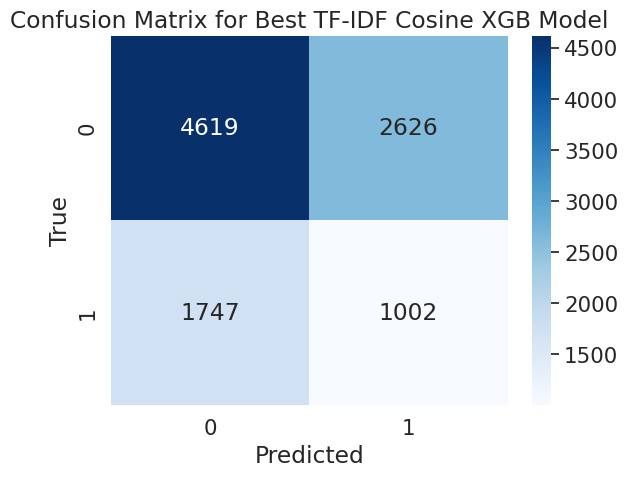

Metrics:
               precision    recall  f1-score   support

           0       0.73      0.64      0.68      7245
           1       0.28      0.36      0.31      2749

    accuracy                           0.56      9994
   macro avg       0.50      0.50      0.50      9994
weighted avg       0.60      0.56      0.58      9994



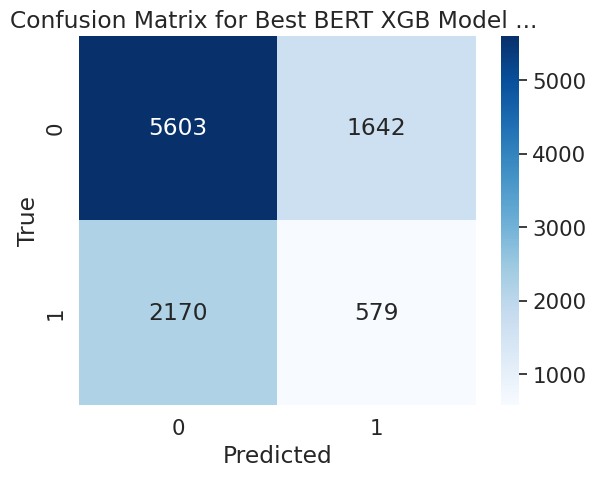

Metrics:
               precision    recall  f1-score   support

           0       0.72      0.77      0.75      7245
           1       0.26      0.21      0.23      2749

    accuracy                           0.62      9994
   macro avg       0.49      0.49      0.49      9994
weighted avg       0.59      0.62      0.61      9994



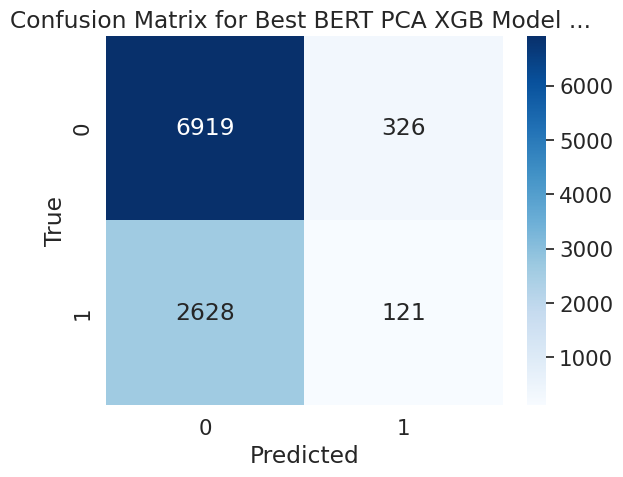

Metrics:
               precision    recall  f1-score   support

           0       0.72      0.96      0.82      7245
           1       0.27      0.04      0.08      2749

    accuracy                           0.70      9994
   macro avg       0.50      0.50      0.45      9994
weighted avg       0.60      0.70      0.62      9994



In [ ]:
# 'Best' as defined by lowest validation loss
# Task 2iii)
plot_confusion_matrix(Y_Test,Cosine_XGB_Test_Preds, 'Confusion Matrix for Best TF-IDF Cosine XGB Model')
plot_confusion_matrix(Y_Test,BE_XGB_Test_Preds, 'Confusion Matrix for Best BERT XGB Model ... ')
plot_confusion_matrix(Y_Test,BE_XGB_PCA_Test_Preds, 'Confusion Matrix for Best BERT PCA XGB Model ... ')

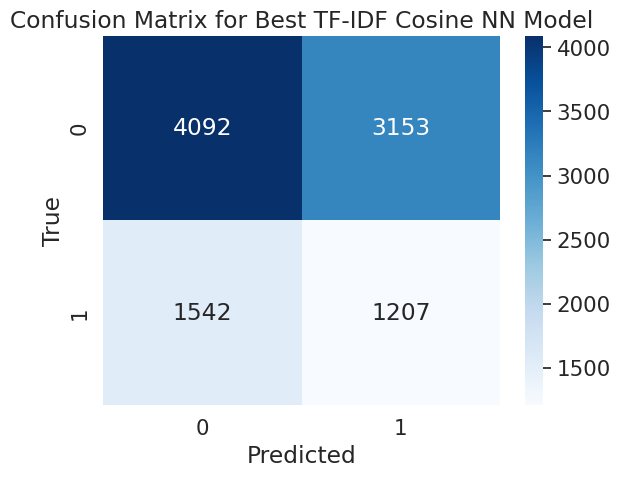

Metrics:
               precision    recall  f1-score   support

           0       0.73      0.56      0.64      7245
           1       0.28      0.44      0.34      2749

    accuracy                           0.53      9994
   macro avg       0.50      0.50      0.49      9994
weighted avg       0.60      0.53      0.55      9994



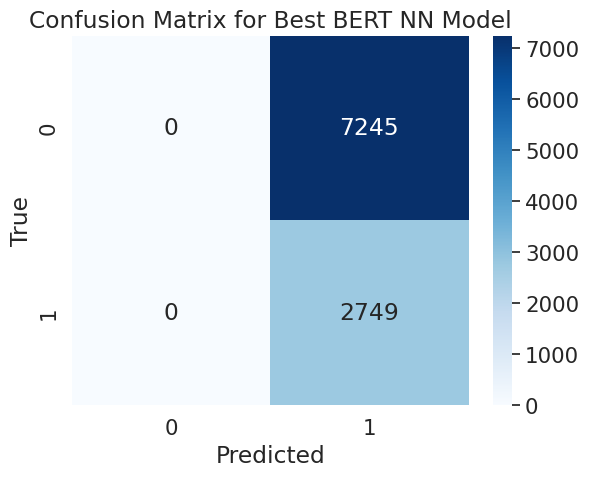

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Metrics:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7245
           1       0.28      1.00      0.43      2749

    accuracy                           0.28      9994
   macro avg       0.14      0.50      0.22      9994
weighted avg       0.08      0.28      0.12      9994



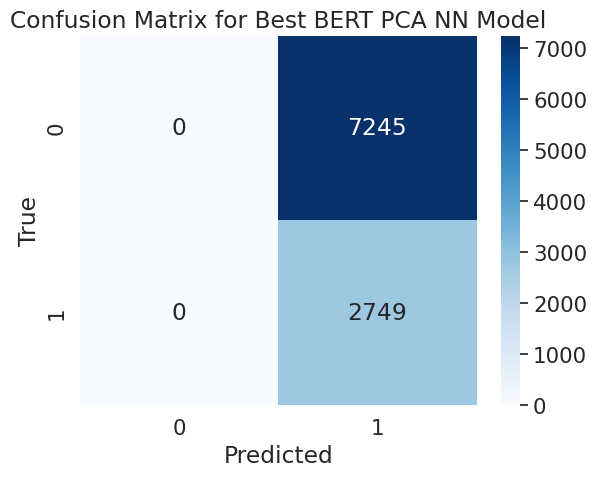

Metrics:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7245
           1       0.28      1.00      0.43      2749

    accuracy                           0.28      9994
   macro avg       0.14      0.50      0.22      9994
weighted avg       0.08      0.28      0.12      9994



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Task 2iii)
plot_confusion_matrix(Y_Test,Cosine_NN_Test_Preds, 'Confusion Matrix for Best TF-IDF Cosine NN Model')
plot_confusion_matrix(Y_Test,BE_NN_Test_Preds, 'Confusion Matrix for Best BERT NN Model')
plot_confusion_matrix(Y_Test,BE_NN_PCA_Test_Preds, 'Confusion Matrix for Best BERT PCA NN Model')

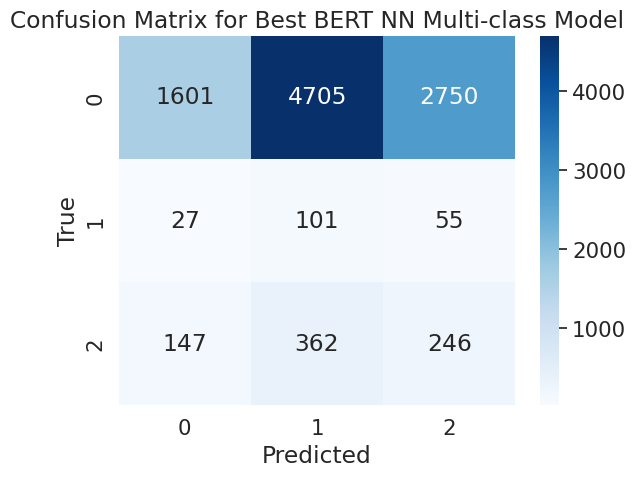

Metrics:
               precision    recall  f1-score   support

           0       0.90      0.18      0.30      9056
           1       0.02      0.55      0.04       183
           2       0.08      0.33      0.13       755

    accuracy                           0.19      9994
   macro avg       0.33      0.35      0.15      9994
weighted avg       0.82      0.19      0.28      9994



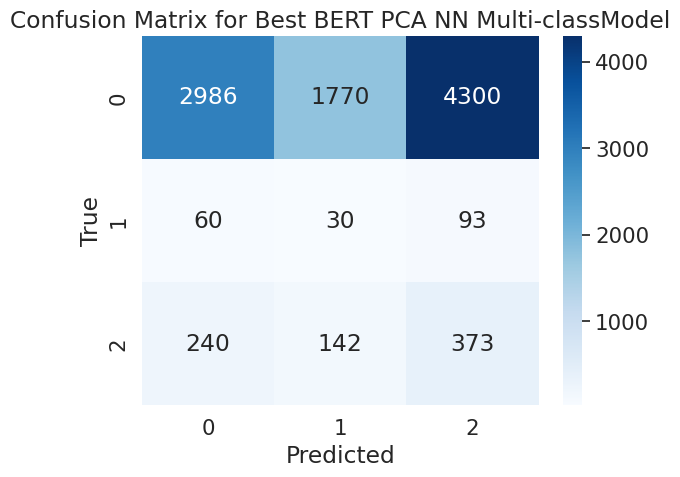

Metrics:
               precision    recall  f1-score   support

           0       0.91      0.33      0.48      9056
           1       0.02      0.16      0.03       183
           2       0.08      0.49      0.14       755

    accuracy                           0.34      9994
   macro avg       0.33      0.33      0.22      9994
weighted avg       0.83      0.34      0.45      9994



In [ ]:
# Task 2bii)
plot_confusion_matrix(Y_Test_ADD_CL,BE_NN_Test_Preds_ADD, 'Confusion Matrix for Best BERT NN Multi-class Model')
plot_confusion_matrix(Y_Test_ADD_CL,BE_NN_PCA_Test_Preds_ADD, 'Confusion Matrix for Best BERT PCA NN Multi-classModel')

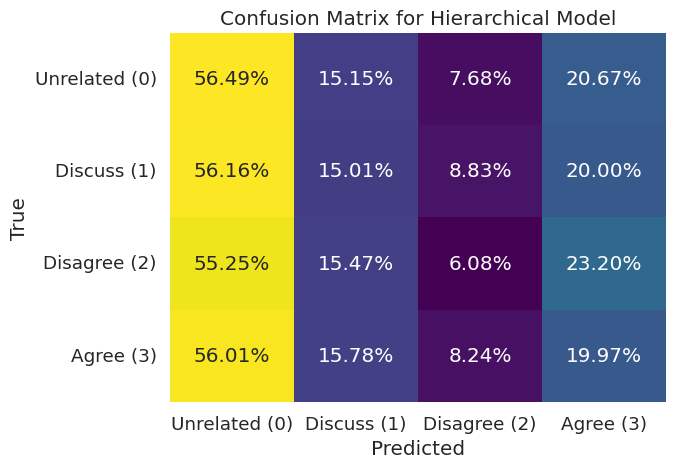

Metrics:
               precision    recall  f1-score   support

           0       0.74      0.56      0.64      7352
           1       0.17      0.15      0.16      1745
           2       0.01      0.06      0.02       181
           3       0.07      0.20      0.10       716

    accuracy                           0.46      9994
   macro avg       0.25      0.24      0.23      9994
weighted avg       0.58      0.46      0.51      9994



In [ ]:
# Task 2c)
plot_confusion_matrix(All_Test_Labels,Combined_Y_Preds, 'Confusion Matrix for Hierarchical Model', labels = ['Unrelated (0)', 'Discuss (1)', 'Disagree (2)', 'Agree (3)'])

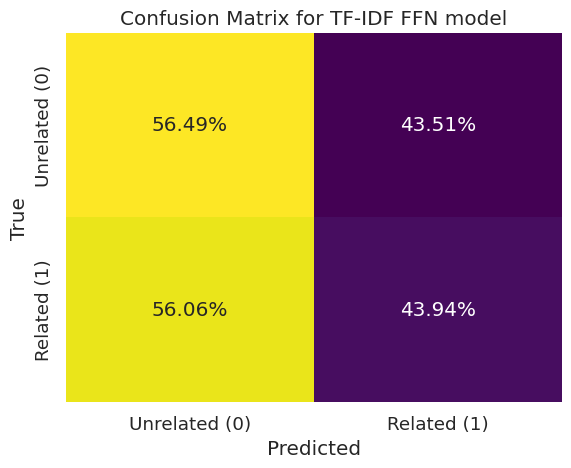

Metrics:
               precision    recall  f1-score   support

           0       0.74      0.56      0.64      7352
           1       0.27      0.44      0.33      2642

    accuracy                           0.53      9994
   macro avg       0.50      0.50      0.49      9994
weighted avg       0.61      0.53      0.56      9994



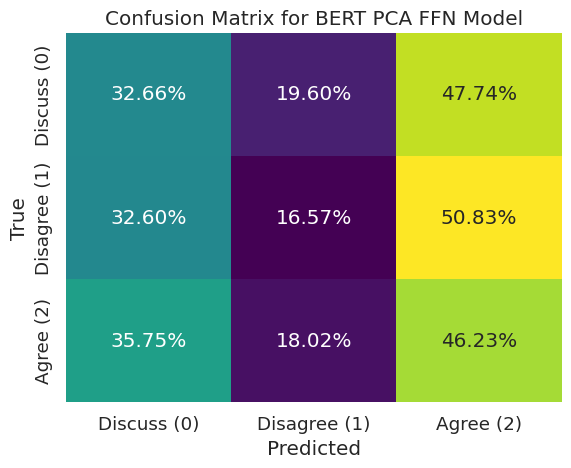

Metrics:
               precision    recall  f1-score   support

           0       0.90      0.33      0.48      9097
           1       0.02      0.17      0.03       181
           2       0.07      0.46      0.12       716

    accuracy                           0.33      9994
   macro avg       0.33      0.32      0.21      9994
weighted avg       0.83      0.33      0.45      9994



In [ ]:
plot_confusion_matrix(Y_Test,Cosine_NN_Test_Preds, 'Confusion Matrix for TF-IDF FFN model', labels = ['Unrelated (0)', 'Related (1)'])
plot_confusion_matrix(Y_Test_ADD_CL,BE_NN_PCA_Test_Preds_ADD, 'Confusion Matrix for BERT PCA FFN Model', labels = ['Discuss (0)', 'Disagree (1)', 'Agree (2)'])